In [ ]:
import tensorflow as tf
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# 1. DRIVE BAĞLANTISI
# Drive baglantisi kopmussa tekrar bagliyoruz, bagliysa devam ediyoruz.
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive baglantisi zaten mevcut.")

# Proje klasor yollarini tanimliyorum
base_path = '/content/drive/My Drive/YapayZekaProjesi'
results_path = os.path.join(base_path, 'Sonuclar')
models_path = os.path.join(base_path, 'Kayitli_Modeller')

# Klasorler yoksa olusturuyorum
if not os.path.exists(results_path): os.makedirs(results_path)
if not os.path.exists(models_path): os.makedirs(models_path)

# 2. ZIP DOSYASINI ACMA VE DUZENLEME
zip_path = '/content/drive/My Drive/Skin Disease Classification Dataset.zip'
extract_path = '/content/dataset_temp'

print("Gecici klasor temizleniyor...")
if os.path.exists(extract_path): shutil.rmtree(extract_path)
os.makedirs(extract_path)

print("Ana zip dosyasi cikartiliyor...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Zip icinde baska zipler (acne.zip vb.) var mi diye kontrol ediyorum.
# Eger varsa onlari da bulundugu yere cikariyorum.
print("Icerideki sikistirilmis dosyalar kontrol ediliyor...")
target_dir = None

for root, dirs, files in os.walk(extract_path):
    for f in files:
        if f.lower().endswith('.zip'):
            # Zip dosyasi buldum, yolunu kaydediyorum
            target_dir = root
            print(f"Bulunan zip dosyasi aciliyor: {f}")

            # Buldugum zip dosyasini klasor olarak cikariyorum
            with zipfile.ZipFile(os.path.join(root, f), 'r') as z:
                z.extractall(os.path.join(root, f.replace('.zip', '')))

    # Eger bir zipi bulursa donguden cıkayım.
    if target_dir:
        break

# Eger zip bulamazsa dıye klasor isimlerinden gitmeyi deniyorum
if target_dir is None:
    for root, dirs, files in os.walk(extract_path):
        lower_dirs = [d.lower() for d in dirs]
        if 'acne' in lower_dirs:
            target_dir = root
            break

if target_dir is None:
    raise ValueError("HATA: Veri seti klasor yapisi beklenmedik sekilde, hastalik klasorleri bulunamadi.")

DATASET_DIR = target_dir
print(f"Veri seti ana dizini tespit edildi: {DATASET_DIR}")

# 3. GEREKSIZ DOSYALARI FILTRELEME
# Proje isterlerine gore hue, saturation ve superpixel goruntulerini siliyorum.
print("Istenmeyen dosyalar (hue, saturation) temizleniyor...")
acne_path = None

# Acne klasorunu kucuk/buyuk harf duyarliligina takilmadan buluyorum
for item in os.listdir(DATASET_DIR):
    if item.lower() == 'acne':
        acne_path = os.path.join(DATASET_DIR, item)
        break

if acne_path:
    deleted_count = 0
    for filename in os.listdir(acne_path):
        fname_lower = filename.lower()
        # Dosya isminde yasakli kelimeler varsa siliyorum
        if "hue" in fname_lower or "saturation" in fname_lower or "superpixels" in fname_lower:
            os.remove(os.path.join(acne_path, filename))
            deleted_count += 1
    print(f"Toplam {deleted_count} adet filtrelenmis goruntu silindi.")
else:
    print("UYARI: Acne klasoru bulunamadi, silme islemi yapilamadi.")

# 4. EGITIM VE TEST VERISINI HAZIRLAMA
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# Veri artirma (Data Augmentation) islemleri
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # Verinin %20'sini test icin ayiriyorum
)

try:
    print("Veriler yukleniyor ve siniflandiriliyor...")
    train_generator = train_datagen.flow_from_directory(
        DATASET_DIR, target_size=IMG_SHAPE, batch_size=BATCH_SIZE,
        class_mode='categorical', subset='training', shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        DATASET_DIR, target_size=IMG_SHAPE, batch_size=BATCH_SIZE,
        class_mode='categorical', subset='validation', shuffle=False
    )

    class_names = list(train_generator.class_indices.keys())
    print(f"Islem tamamlandi. Toplam goruntu sayisi: {train_generator.samples + validation_generator.samples}")
    print(f"Tespit edilen siniflar: {class_names}")

except Exception as e:
    print(f"HATA: Klasor yolu ile ilgili bir sorun olustu.")
    raise e

Mounted at /content/drive
Gecici klasor temizleniyor...
Ana zip dosyasi cikartiliyor...
Icerideki sikistirilmis dosyalar kontrol ediliyor...
Bulunan zip dosyasi aciliyor: hyperpigmentation.zip
Bulunan zip dosyasi aciliyor: Vitiligo.zip
Bulunan zip dosyasi aciliyor: Nail_psoriasis.zip
Bulunan zip dosyasi aciliyor: SJS-TEN.zip
Bulunan zip dosyasi aciliyor: acne.zip
Veri seti ana dizini tespit edildi: /content/dataset_temp/Skin Disease Classification Dataset/New folder
Istenmeyen dosyalar (hue, saturation) temizleniyor...
Toplam 0 adet filtrelenmis goruntu silindi.
Veriler yukleniyor ve siniflandiriliyor...
Found 7640 images belonging to 5 classes.
Found 1908 images belonging to 5 classes.
Islem tamamlandi. Toplam goruntu sayisi: 9548
Tespit edilen siniflar: ['Nail_psoriasis', 'SJS-TEN', 'Vitiligo', 'acne', 'hyperpigmentation']


In [ ]:
#  MODEL EĞİTİM VE RAPORLAMA FONKSİYONU
# Bu fonksiyonu tüm modellerim için ortak kullanacağım.
def train_evaluate_save(model, model_name, epochs=50):

    # Model daha önce eğitildiyse tekrar çalıştırma (Zaman kazancı)
    if os.path.exists(f"{models_path}/{model_name}_best.h5"):
        print(f"⏩ {model_name} zaten kayıtlı, bu adımı atlıyorum...")
        return

    print(f"\n{'='*40}")
    print(f" MODEL EĞİTİMİ BAŞLIYOR: {model_name}")
    print(f" Hedeflenen Epoch: {epochs}")
    print(f"{'='*40}")

    # Callback: Sadece en yüksek doğruluk (val_accuracy) değerini yakaladığım anı kaydediyorum.
    # Böylece model 50 epoch sürse bile, aşırı öğrenme (overfitting) olmadan önceki en iyi halini alırım.
    checkpoint = ModelCheckpoint(f"{models_path}/{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

    # Eğitimi başlatıyorum
    start_time = time.time()
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[checkpoint], # Erken durdurmasını ıstemıyorum, 50 epoch zorunlu.
        verbose=1
    )
    end_time = time.time()
    avg_time = (end_time - start_time) / len(history.epoch)

    # SONUÇLARI GÖRSELLEŞTİRME VE KAYDETME

    # 1. Başarı (Accuracy) ve Kayıp (Loss) Grafikleri
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Başarısı')
    plt.plot(history.history['val_accuracy'], label='Test Başarısı')
    plt.title(f'{model_name} - Doğruluk Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Hatası')
    plt.plot(history.history['val_loss'], label='Test Hatası')
    plt.title(f'{model_name} - Kayıp (Loss) Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.savefig(f"{results_path}/{model_name}_Graph.png") # Grafiği Drive'a atsın ıstıyprum
    plt.show() # Ekrana bassın
    plt.close()

    # 2. Karmaşıklık Matrisi (Confusion Matrix)
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Karmaşıklık Matrisi')
    plt.ylabel('Gerçek Sınıf')
    plt.xlabel('Tahmin Edilen Sınıf')
    plt.savefig(f"{results_path}/{model_name}_CM.png")
    plt.show()
    plt.close()

    # 3. Sonuçları Excel Tablosuna İşleme
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    new_row = {
        "Model Adi": model_name,
        "Epoch Sayisi": epochs,
        "Dogruluk (Accuracy)": round(acc, 4),
        "F1-Skoru": round(f1, 4),
        "Hassasiyet (Precision)": round(prec, 4),
        "Duyarlilik (Recall)": round(rec, 4),
        "Egitim Suresi (sn)": round(avg_time, 2)
    }

    # Excel dosyasını güncelleme
    try: df = pd.read_excel(f"{results_path}/Sonuc_Tablosu.xlsx")
    except: df = pd.DataFrame()

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_excel(f"{results_path}/Sonuc_Tablosu.xlsx", index=False)

    # Bellek temizliği
    del model, history
    tf.keras.backend.clear_session()
    gc.collect()
    print(f" {model_name} başarıyla tamamlandı ve kaydedildi.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from tensorflow.keras.callbacks import ModelCheckpoint

# --- GUNCEL ANA FONKSIYON (RAMİ SAĞLIKLI KULLANMAM ICIN VE HER SEYI KAYDEDEN) ---
def train_evaluate_save(model, model_name, epochs=50):

    # Model daha once egitildiyse tekrar egitmesını ıstemıyorum, sadece sonuc gostersın ıstıyorum
    if os.path.exists(f"{models_path}/{model_name}_best.h5"):
        print(f">> {model_name} zaten kayitli. Grafikler hazirlaniyor...")
        # Modeli yukle
        model = tf.keras.models.load_model(f"{models_path}/{model_name}_best.h5")
        # History grafigi egitim bittigi icin cizilemez, pas geciyorum.
    else:
        print(f"Model Egitiliyor: {model_name}...")
        checkpoint = ModelCheckpoint(f"{models_path}/{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

        history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint], verbose=1)

        # 1. LOSS / ACCURACY GRAFIGI
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1); plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']); plt.title('Accuracy'); plt.legend(['Train', 'Val'])
        plt.subplot(1, 2, 2); plt.plot(history.history['loss']); plt.plot(history.history['val_loss']); plt.title('Loss'); plt.legend(['Train', 'Val'])
        plt.savefig(f"{results_path}/{model_name}_Graph.png")
        plt.show()
        plt.close() #  RAM temizligi icin ekledim colab tarafında daha verımlı calısmak ıcın

    # TAHMINLER
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # 2. MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Matrix')
    plt.savefig(f"{results_path}/{model_name}_CM.png")
    plt.show()
    plt.close() # RAM temizligi yaptırdım.

    # 3. ROC (SAYILI VERSIYON)
    plt.figure(figsize=(10, 8))
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--'); plt.title(f'{model_name} ROC'); plt.legend(loc="lower right")
    plt.savefig(f"{results_path}/{model_name}_ROC.png")
    plt.show()
    plt.close() # <RAM temizligi

    # EXCEL KAYDI
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    new_row = {"Model Adi": model_name, "Epoch": epochs, "Accuracy": round(acc, 4), "F1-Score": round(f1, 4)}

    try: df = pd.read_excel(f"{results_path}/Sonuc_Tablosu.xlsx")
    except: df = pd.DataFrame()

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_excel(f"{results_path}/Sonuc_Tablosu.xlsx", index=False)

    # Arka planda sismeyi onlemek icin cop toplayiciyi calistirdim
    gc.collect()

    print(f"{model_name} ISLEMLERI TAMAMLANDI!")

 Veri dağılım grafiği oluşturuyorum...


/tmp/ipython-input-4178629545.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette="viridis")


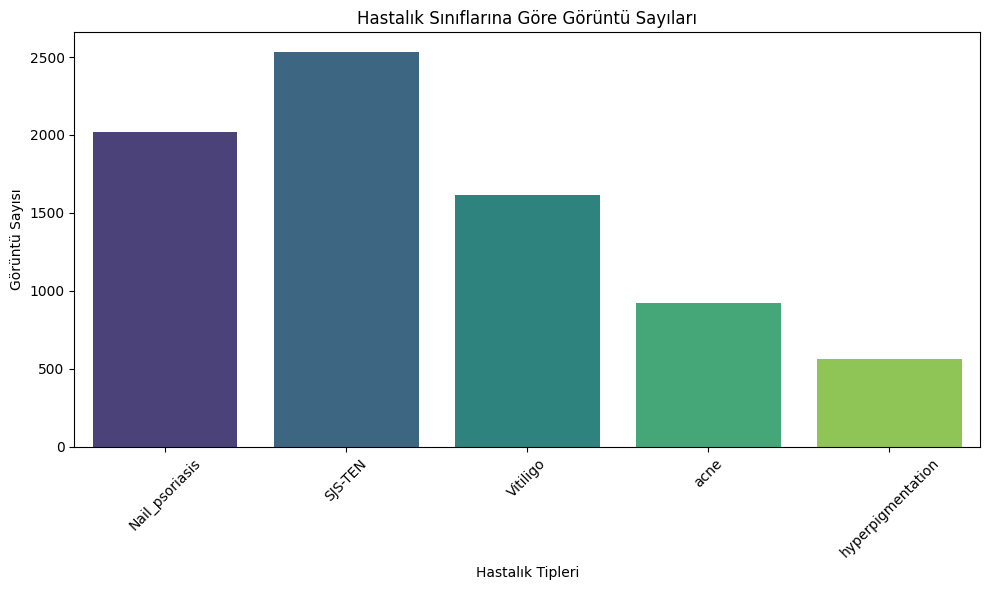

Grafik çizildi ve '/content/drive/My Drive/YapayZekaProjesi/Sonuclar' klasörüne kaydedildi.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Hafızadaki verileri kullanarak grafiği çiziyorum
print(" Veri dağılım grafiği oluşturuyorum...")

# Sınıf isimlerini ve sayılarını alıyorum
class_counts = train_generator.classes
unique, counts = np.unique(class_counts, return_counts=True)

# Grafiği çiziyorum
plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=counts, palette="viridis")

plt.title("Hastalık Sınıflarına Göre Görüntü Sayıları")
plt.ylabel("Görüntü Sayısı")
plt.xlabel("Hastalık Tipleri")
plt.xticks(rotation=45) # İsimler sığsın diye yan çeviriyorum

# Hem ekrana basıp hem kaydetiyorum
plt.tight_layout()
plt.savefig(f"{results_path}/Veri_Analizi_Grafigi.png")
plt.show()

print(f"Grafik çizildi ve '{results_path}' klasörüne kaydedildi.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 MODEL EĞİTİMİ BAŞLIYOR: Model_01_Custom_CNN
 Hedeflenen Epoch: 50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.3985 - loss: 1.5538
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 122s 467ms/step - accuracy: 0.3987 - loss: 1.5528 - val_accuracy: 0.3333 - val_loss: 1.5180
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5511 - loss: 1.0760
Epoch 2: val_accuracy improved from 0.33333 to 0.56342, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.5512 - loss: 1.0758 - val_accuracy: 0.5634 - val_loss: 1.1079
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6208 - loss: 0.9349
Epoch 3: val_accuracy improved from 0.56342 to 0.67296, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.6208 - loss: 0.9348 - val_accuracy: 0.6730 - val_loss: 0.8563
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6562 - loss: 0.8548
Epoch 4: val_accuracy improved from 0.67296 to 0.74266, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.6563 - loss: 0.8548 - val_accuracy: 0.7427 - val_loss: 0.6829
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7176 - loss: 0.7311
Epoch 5: val_accuracy improved from 0.74266 to 0.76572, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 435ms/step - accuracy: 0.7175 - loss: 0.7311 - val_accuracy: 0.7657 - val_loss: 0.6276
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7437 - loss: 0.6740
Epoch 6: val_accuracy improved from 0.76572 to 0.79560, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.7437 - loss: 0.6740 - val_accuracy: 0.7956 - val_loss: 0.5642
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7508 - loss: 0.6384
Epoch 7: val_accuracy did not improve from 0.79560
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7508 - loss: 0.6382 - val_accuracy: 0.7678 - val_loss: 0.6465
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7853 - loss: 0.5460
Epoch 8: val_accuracy improved from 0.79560 to 0.83648, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 435ms/step - accuracy: 0.7854 - loss: 0.5459 - val_accuracy: 0.8365 - val_loss: 0.4526
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8112 - loss: 0.5028
Epoch 9: val_accuracy improved from 0.83648 to 0.85273, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 438ms/step - accuracy: 0.8112 - loss: 0.5027 - val_accuracy: 0.8527 - val_loss: 0.4422
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8227 - loss: 0.4711
Epoch 10: val_accuracy did not improve from 0.85273
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8227 - loss: 0.4711 - val_accuracy: 0.8166 - val_loss: 0.4853
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8301 - loss: 0.4418
Epoch 11: val_accuracy improved from 0.85273 to 0.85482, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.8302 - loss: 0.4417 - val_accuracy: 0.8548 - val_loss: 0.3934
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8529 - loss: 0.4048
Epoch 12: val_accuracy improved from 0.85482 to 0.86583, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.8529 - loss: 0.4048 - val_accuracy: 0.8658 - val_loss: 0.3570
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8627 - loss: 0.3616
Epoch 13: val_accuracy did not improve from 0.86583
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.8627 - loss: 0.3616 - val_accuracy: 0.8606 - val_loss: 0.3586
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8779 - loss: 0.3404
Epoch 14: val_accuracy improved from 0.86583 to 0.88627, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.8779 - loss: 0.3404 - val_accuracy: 0.8863 - val_loss: 0.3333
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8715 - loss: 0.3414
Epoch 15: val_accuracy improved from 0.88627 to 0.89727, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.8715 - loss: 0.3413 - val_accuracy: 0.8973 - val_loss: 0.2828
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9003 - loss: 0.2773
Epoch 16: val_accuracy did not improve from 0.89727
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 423ms/step - accuracy: 0.9003 - loss: 0.2773 - val_accuracy: 0.8947 - val_loss: 0.3041
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8960 - loss: 0.2783
Epoch 17: val_accuracy improved from 0.89727 to 0.90356, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.8960 - loss: 0.2783 - val_accuracy: 0.9036 - val_loss: 0.2939
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8976 - loss: 0.2813
Epoch 18: val_accuracy did not improve from 0.90356
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.8976 - loss: 0.2812 - val_accuracy: 0.8968 - val_loss: 0.3215
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9199 - loss: 0.2404
Epoch 19: val_accuracy did not improve from 0.90356
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 425ms/step - accuracy: 0.9199 - loss: 0.2404 - val_accuracy: 0.8795 - val_loss: 0.3577
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9220 - loss: 0.2268
Epoch 20: val_accuracy did not improve from 0.90356
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.9220 - loss: 0.2268 - val_accuracy: 0.8936 - val_loss: 0.2908
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9232 - loss: 0.2184
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.9223 - loss: 0.2086 - val_accuracy: 0.9140 - val_loss: 0.2450
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9255 - loss: 0.2060
Epoch 23: val_accuracy did not improve from 0.91405
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9255 - loss: 0.2060 - val_accuracy: 0.9125 - val_loss: 0.2769
Epoch 24/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9296 - loss: 0.1912
Epoch 24: val_accuracy improved from 0.91405 to 0.92558, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.9296 - loss: 0.1912 - val_accuracy: 0.9256 - val_loss: 0.2290
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9308 - loss: 0.1899
Epoch 25: val_accuracy did not improve from 0.92558
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.9308 - loss: 0.1899 - val_accuracy: 0.9209 - val_loss: 0.2531
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9458 - loss: 0.1588
Epoch 26: val_accuracy did not improve from 0.92558
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9457 - loss: 0.1588 - val_accuracy: 0.9224 - val_loss: 0.2221
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9372 - loss: 0.1711
Epoch 27: val_accuracy did not improve from 0.92558
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.9372 - loss: 0.1711 - val_accuracy: 0.9177 - val_loss: 0.2442
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9407 - loss: 0.1589
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.9407 - loss: 0.1589 - val_accuracy: 0.9277 - val_loss: 0.2348
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9457 - loss: 0.1479
Epoch 29: val_accuracy did not improve from 0.92767
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9457 - loss: 0.1479 - val_accuracy: 0.9193 - val_loss: 0.2424
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9448 - loss: 0.1477
Epoch 30: val_accuracy improved from 0.92767 to 0.94130, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.9448 - loss: 0.1477 - val_accuracy: 0.9413 - val_loss: 0.1822
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9381 - loss: 0.1593
Epoch 31: val_accuracy did not improve from 0.94130
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.9381 - loss: 0.1593 - val_accuracy: 0.9251 - val_loss: 0.2208
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9538 - loss: 0.1286
Epoch 32: val_accuracy did not improve from 0.94130
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.9538 - loss: 0.1286 - val_accuracy: 0.9308 - val_loss: 0.2551
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9529 - loss: 0.1303
Epoch 33: val_accuracy did not improve from 0.94130
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9529 - loss: 0.1303 - val_accuracy: 0.9156 - val_loss: 0.2876
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9548 - loss: 0.1306
Epoc

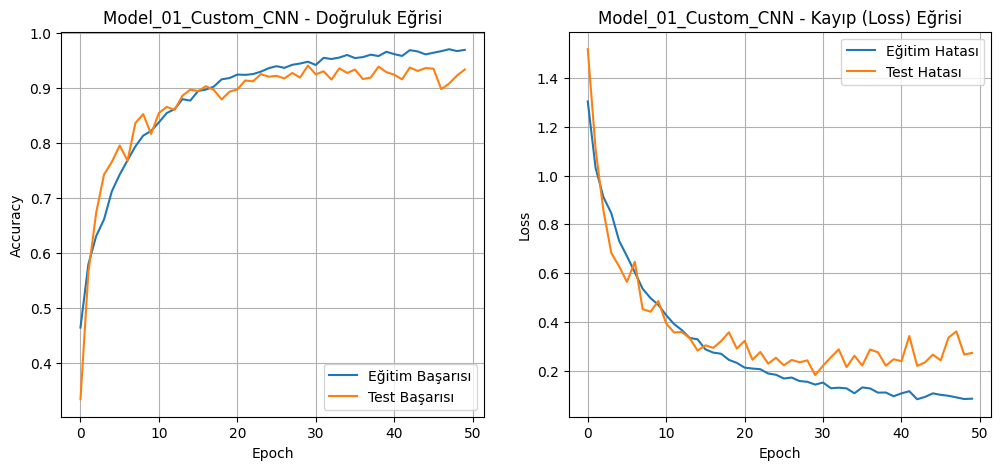

60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 338ms/step


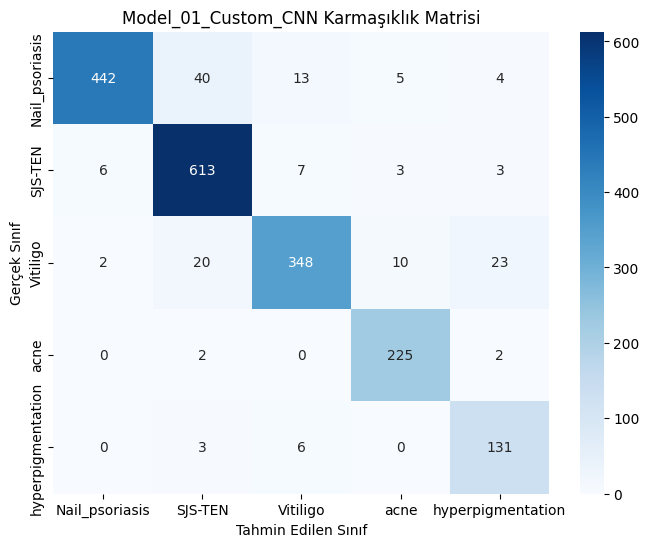

 Model_01_Custom_CNN başarıyla tamamlandı ve kaydedildi.


In [ ]:
# --- MODEL 1: Custom CNN (KENDİ ÖZGÜN MODELİM) ---
# Burada katmanları kendim tasarlayarak özgün bir model oluşturuyorum.
def create_custom_model():
    model = tf.keras.models.Sequential([
        # Özellik Çıkarımı (Feature Extraction) Katmanları
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(), # Öğrenmeyi hızlandırmak için yaptım

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        # Sınıflandırma (Classification) Katmanları
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3), # Ezberlemeyi (Overfitting) engellemek için bunu yaptım
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Modeli oluşturup eğitiyorum
my_model = create_custom_model()
train_evaluate_save(my_model, "Model_01_Custom_CNN", epochs=50)

Kayitli model dosyasi bulundu, yukleniyor: /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_01_Custom_CNN_best.h5


Test verileri uzerinde tahmin yapiliyor...
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 339ms/step


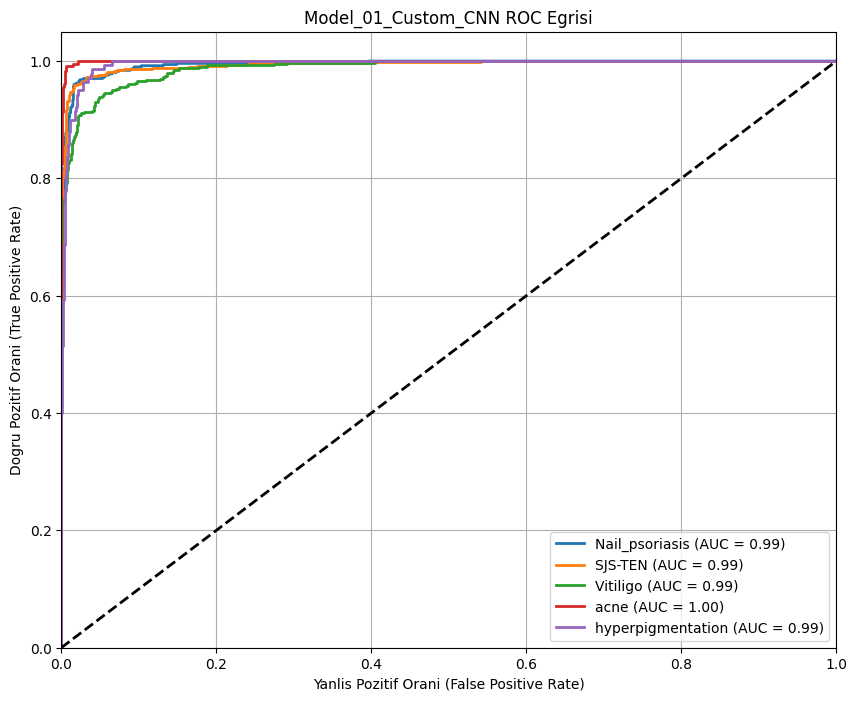

Islem basarili. ROC egrisi suraya kaydedildi: /content/drive/My Drive/YapayZekaProjesi/Sonuclar/Model_01_Custom_CNN_ROC.png


In [ ]:
# ROC EGRISINI CIZDIRME KODUMU YAZIYORUM.
# Egitimi tamamlanmis olan Model 1'i yukleyip sadece ROC grafigini olusturuyorum.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os

# Model ismini ve dosya yolunu tanimliyorum
target_model_name = "Model_01_Custom_CNN"
model_file_path = f"{models_path}/{target_model_name}_best.h5"

# 1. Kayitli model dosyasinin varligini kontrol ediyorum
if os.path.exists(model_file_path):
    print(f"Kayitli model dosyasi bulundu, yukleniyor: {model_file_path}")

    # Modeli yukluyorum
    loaded_model = tf.keras.models.load_model(model_file_path)

    # 2. Test (Validation) verisi uzerinde tahmin yapiyorum
    print("Test verileri uzerinde tahmin yapiliyor...")
    validation_generator.reset() # Generator'i basa sariyorum

    # Modelin olasilik tahminlerini aliyorum (Prediction)
    Y_pred = loaded_model.predict(validation_generator, verbose=1)
    y_true = validation_generator.classes # Gercek etiketler

    # 3. ROC Egrisi icin verileri hazirliyorum
    # Coklu siniflandirma oldugu icin etiketleri binary (0-1) formatina ceviriyorum
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)

    # Grafigi ciziyorum
    plt.figure(figsize=(10, 8))

    # Her bir hastalik sinifi icin ayri ayri egri cizdiriyorum
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc = auc(fpr, tpr) # Egri altinda kalan alani (AUC) hesapliyorum

        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    # Referans cizgisi
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Yanlis Pozitif Orani (False Positive Rate)')
    plt.ylabel('Dogru Pozitif Orani (True Positive Rate)')
    plt.title(f'{target_model_name} ROC Egrisi')
    plt.legend(loc="lower right")
    plt.grid(True)

    # 4. Grafigi Drive'a kaydediyorum
    save_path = f"{results_path}/{target_model_name}_ROC.png"
    plt.savefig(save_path)
    plt.show()

    print(f"Islem basarili. ROC egrisi suraya kaydedildi: {save_path}")

else:
    print(f"HATA: Model dosyasi bulunamadi! Lutfen once modeli egitin.")

In [ ]:
#  DUZELTILMIS EGITIM FONKSIYONUM GRAFIKLERIM ICIN ---
#  plt.show() U eklemeyı unutmustum o yuzden ıstedıgım her seyın cıktısını goremedım sımdı buna ayar cekecegım.
# Simdi hem Drive'a kaydedecek hem de ekrana basacak sekilde guncelledim.

def train_evaluate_save(model, model_name, epochs=50):

    if os.path.exists(f"{models_path}/{model_name}_best.h5"):
        print(f">> {model_name} zaten kayitli, islem atlaniliyor.")
        return

    print(f"\n{'='*40}")
    print(f"MODEL EGITIMI BASLIYOR: {model_name}")
    print(f"Hedef Epoch: {epochs}")
    print(f"{'='*40}")

    checkpoint = ModelCheckpoint(f"{models_path}/{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

    start_time = time.time()
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=[checkpoint], verbose=1)
    end_time = time.time()
    avg_time = (end_time - start_time) / len(history.epoch)

    # 1. LOSS ve ACCURACY GRAFIKLERI
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Egitim (Train)')
    plt.plot(history.history['val_accuracy'], label='Test (Validation)')
    plt.title(f'{model_name} - Dogruluk')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Egitim (Train)')
    plt.plot(history.history['val_loss'], label='Test (Validation)')
    plt.title(f'{model_name} - Kayip (Loss)')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

    plt.savefig(f"{results_path}/{model_name}_Graph.png")
    plt.show() # Artik ekranda gozukecek
    plt.close()

    # TAHMINLER
    validation_generator.reset()
    Y_pred = model.predict(validation_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # 2. CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Karmasiklik Matrisi')
    plt.savefig(f"{results_path}/{model_name}_CM.png")
    plt.show() # <EKRANDA GOZUKSUN
    plt.close()

    # 3. ROC EGRISI
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Egrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig(f"{results_path}/{model_name}_ROC.png")
    plt.show() # ekrana yazdırsın
    plt.close()

    # 4. EXCEL KAYDI YAPTIRIYORUM
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    new_row = {"Model Adi": model_name, "Epoch": epochs, "Accuracy": round(acc, 4), "F1-Score": round(f1, 4), "Sure(sn)": round(avg_time, 2)}

    try: df = pd.read_excel(f"{results_path}/Sonuc_Tablosu.xlsx")
    except: df = pd.DataFrame()

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    df.to_excel(f"{results_path}/Sonuc_Tablosu.xlsx", index=False)

    tf.keras.backend.clear_session()
    gc.collect()
    print(f"ISLEM TAMAM: {model_name} basariyla kaydedildi ve gosterildi.")

In [ ]:
from tensorflow.keras.applications import VGG16

# --- MODEL 2: VGG16 ---
# Overfitting'i engellemek icin L2 Regularization ve %50 Dropout kullaniyorum.
print("VGG16 modeli hazirlaniyor...")
base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)), # L2 ekledim ıstedıgım gıbı olsun dıye
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5), # Dropout artirildi
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
train_evaluate_save(model, "Model_02_VGG16", epochs=50)

VGG16 modeli hazirlaniyor...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

MODEL EGITIMI BASLIYOR: Model_02_VGG16
Hedef Epoch: 50
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.3625 - loss: 4.7615
Epoch 1: val_accuracy improved from -inf to 0.61059, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 473ms/step - accuracy: 0.3628 - loss: 4.7595 - val_accuracy: 0.6106 - val_loss: 3.5401
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5425 - loss: 3.3328
Epoch 2: val_accuracy improved from 0.61059 to 0.65723, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.5426 - loss: 3.3320 - val_accuracy: 0.6572 - val_loss: 2.6618
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5777 - loss: 2.6719
Epoch 3: val_accuracy improved from 0.65723 to 0.68606, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.5777 - loss: 2.6715 - val_accuracy: 0.6861 - val_loss: 2.1850
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6097 - loss: 2.2734
Epoch 4: val_accuracy improved from 0.68606 to 0.68868, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.6098 - loss: 2.2730 - val_accuracy: 0.6887 - val_loss: 1.9573
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6392 - loss: 2.0207
Epoch 5: val_accuracy improved from 0.68868 to 0.71226, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.6392 - loss: 2.0205 - val_accuracy: 0.7123 - val_loss: 1.7360
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6585 - loss: 1.8518
Epoch 6: val_accuracy improved from 0.71226 to 0.71488, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.6585 - loss: 1.8516 - val_accuracy: 0.7149 - val_loss: 1.6355
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6661 - loss: 1.7042
Epoch 7: val_accuracy improved from 0.71488 to 0.73218, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.6661 - loss: 1.7041 - val_accuracy: 0.7322 - val_loss: 1.5280
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6810 - loss: 1.5943
Epoch 8: val_accuracy did not improve from 0.73218
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.6810 - loss: 1.5943 - val_accuracy: 0.6813 - val_loss: 1.5540
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6839 - loss: 1.5162
Epoch 9: val_accuracy did not improve from 0.73218
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.6840 - loss: 1.5161 - val_accuracy: 0.7039 - val_loss: 1.4000
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6903 - loss: 1.4451
Epoch 10: val_accuracy improved from 0.73218 to 0.74423, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.6903 - loss: 1.4450 - val_accuracy: 0.7442 - val_loss: 1.2882
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6938 - loss: 1.3704
Epoch 11: val_accuracy did not improve from 0.74423
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.6938 - loss: 1.3703 - val_accuracy: 0.7416 - val_loss: 1.2491
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7130 - loss: 1.2878
Epoch 12: val_accuracy did not improve from 0.74423
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7130 - loss: 1.2878 - val_accuracy: 0.7128 - val_loss: 1.2691
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6966 - loss: 1.2680
Epoch 13: val_accuracy improved from 0.74423 to 0.76310, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.6967 - loss: 1.2679 - val_accuracy: 0.7631 - val_loss: 1.1209
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7325 - loss: 1.1818
Epoch 14: val_accuracy did not improve from 0.76310
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7325 - loss: 1.1819 - val_accuracy: 0.7610 - val_loss: 1.1069
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7160 - loss: 1.1804
Epoch 15: val_accuracy did not improve from 0.76310
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 423ms/step - accuracy: 0.7160 - loss: 1.1803 - val_accuracy: 0.7028 - val_loss: 1.1425
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7254 - loss: 1.1342
Epoch 16: val_accuracy did not improve from 0.76310
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7253 - loss: 1.1342 - val_accuracy: 0.7626 - val_loss: 1.0279
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7221 - loss: 1.1142
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.7221 - loss: 1.1142 - val_accuracy: 0.7762 - val_loss: 1.0062
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7395 - loss: 1.0517
Epoch 18: val_accuracy did not improve from 0.77621
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7395 - loss: 1.0518 - val_accuracy: 0.7683 - val_loss: 1.0180
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7402 - loss: 1.0487
Epoch 19: val_accuracy did not improve from 0.77621
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7402 - loss: 1.0487 - val_accuracy: 0.7495 - val_loss: 0.9911
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7396 - loss: 1.0233
Epoch 20: val_accuracy did not improve from 0.77621
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7397 - loss: 1.0232 - val_accuracy: 0.7421 - val_loss: 0.9912
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7434 - loss: 0.9956
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 430ms/step - accuracy: 0.7496 - loss: 0.9475 - val_accuracy: 0.7862 - val_loss: 0.8872
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7459 - loss: 0.9282
Epoch 25: val_accuracy did not improve from 0.78616
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7459 - loss: 0.9281 - val_accuracy: 0.7657 - val_loss: 0.8795
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7639 - loss: 0.8913
Epoch 26: val_accuracy did not improve from 0.78616
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 430ms/step - accuracy: 0.7638 - loss: 0.8913 - val_accuracy: 0.7573 - val_loss: 0.8856
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7558 - loss: 0.8811
Epoch 27: val_accuracy did not improve from 0.78616
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7558 - loss: 0.8812 - val_accuracy: 0.7773 - val_loss: 0.8396
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7541 - loss: 0.8795
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.7602 - loss: 0.8356 - val_accuracy: 0.7982 - val_loss: 0.7647
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7601 - loss: 0.8186
Epoch 34: val_accuracy did not improve from 0.79822
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.7601 - loss: 0.8186 - val_accuracy: 0.7206 - val_loss: 0.8749
Epoch 35/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7581 - loss: 0.8132
Epoch 35: val_accuracy improved from 0.79822 to 0.80765, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_02_VGG16_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.7581 - loss: 0.8132 - val_accuracy: 0.8077 - val_loss: 0.7402
Epoch 36/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7659 - loss: 0.8050
Epoch 36: val_accuracy did not improve from 0.80765
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7659 - loss: 0.8050 - val_accuracy: 0.7898 - val_loss: 0.7663
Epoch 37/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7695 - loss: 0.7866
Epoch 37: val_accuracy did not improve from 0.80765
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7694 - loss: 0.7867 - val_accuracy: 0.7883 - val_loss: 0.7634
Epoch 38/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7746 - loss: 0.7743
Epoch 38: val_accuracy did not improve from 0.80765
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.7746 - loss: 0.7743 - val_accuracy: 0.7568 - val_loss: 0.8011
Epoch 39/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7673 - loss: 0.7841
Epoc

Model_02_VGG16 sonuclari hazirlaniyor...


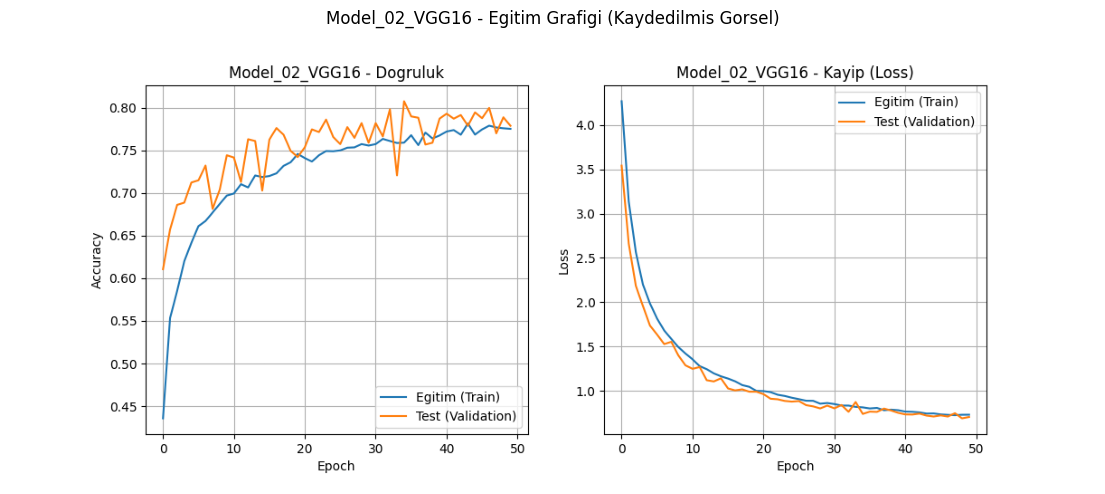

Model yukleniyor, lutfen bekleyiniz...


60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step


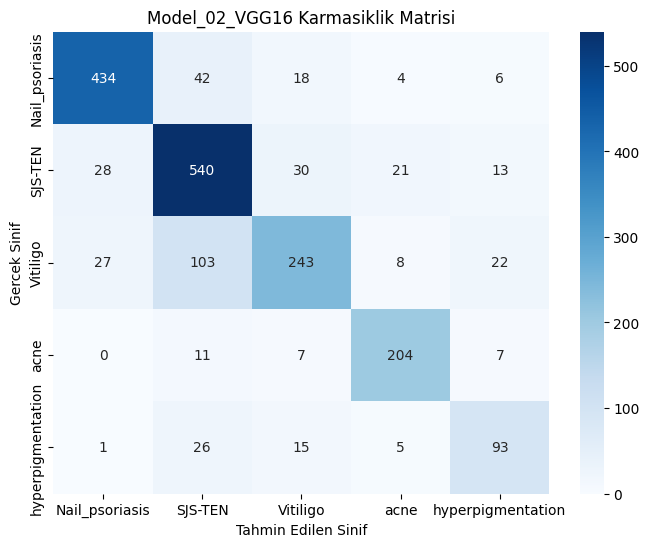

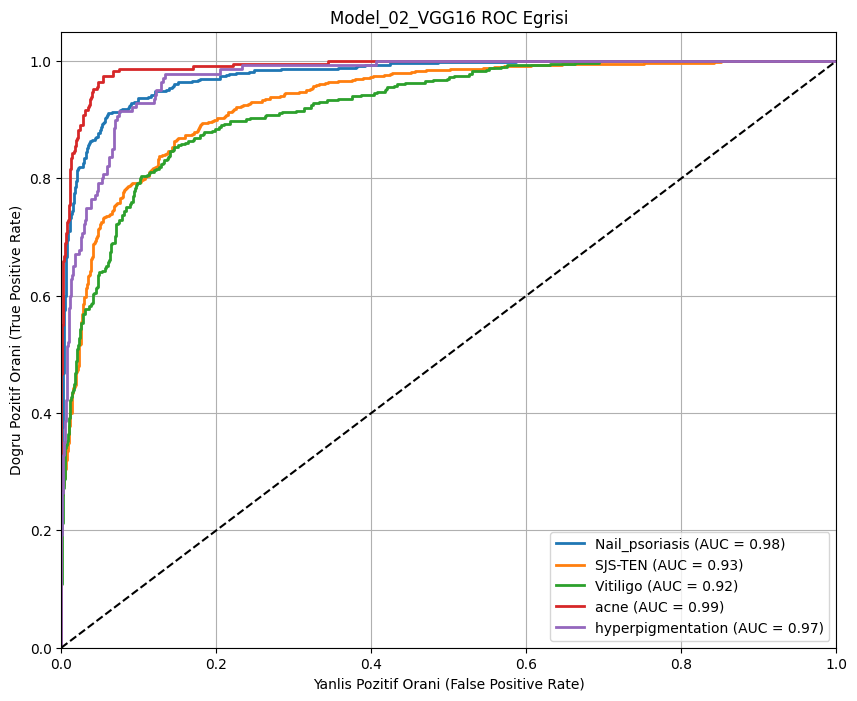

Tum grafikler basariyla gosterildi.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- MODEL 2 SONUCLARINI GORSELLESTIRME ---
# Egitim tamamlandigi icin kayitli grafikleri ve modeli cagirarak
# Accuracy, Confusion Matrix ve ROC egrisini ekrana bastiriyorum.

model_name = "Model_02_VGG16"
model_path = f"{models_path}/{model_name}_best.h5"
graph_path = f"{results_path}/{model_name}_Graph.png"

print(f"{model_name} sonuclari hazirlaniyor...")

# 1. KAYDEDILMIS ACCURACY / LOSS GRAFIGINI GOSTERTTIIM
if os.path.exists(graph_path):
    plt.figure(figsize=(14, 6))
    img = mpimg.imread(graph_path)
    plt.imshow(img)
    plt.axis('off') # Cerceveyi gizledım
    plt.title(f"{model_name} - Egitim Grafigi (Kaydedilmis Gorsel)")
    plt.show()
else:
    print("Bilgi: Accuracy grafigi dosyasi bulunamadi.")

# 2. MODELI YUKLE VE TAHMIN YAP METODUNU HAZIRLIYORUM (Matrix ve ROC icin)
if os.path.exists(model_path):
    print("Model yukleniyor, lutfen bekleyiniz...")
    loaded_model = tf.keras.models.load_model(model_path)

    validation_generator.reset()
    Y_pred = loaded_model.predict(validation_generator, verbose=1)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes

    # --- CONFUSION MATRIX ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Karmasiklik Matrisi')
    plt.ylabel('Gercek Sinif')
    plt.xlabel('Tahmin Edilen Sinif')
    plt.show()

    # --- ROC EGRISI ---
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--') # Rastgele tahmin cizgisi
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Yanlis Pozitif Orani (False Positive Rate)')
    plt.ylabel('Dogru Pozitif Orani (True Positive Rate)')
    plt.title(f'{model_name} ROC Egrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    print("Tum grafikler basariyla gosterildi.")

else:
    print(f"HATA: {model_name} dosyasi bulunamadi. Once modeli egitmeniz gerekiyor.")

Model 3 (VGG19) optimize edilmis ayarlarla hazirlaniyor...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

MODEL EGITIMI BASLIYOR: Model_03_VGG19
Hedef Epoch: 50
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3368 - loss: 2.2957
Epoch 1: val_accuracy improved from -inf to 0.51992, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 470ms/step - accuracy: 0.3370 - loss: 2.2946 - val_accuracy: 0.5199 - val_loss: 1.6177
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5289 - loss: 1.6091
Epoch 2: val_accuracy improved from 0.51992 to 0.64990, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.5289 - loss: 1.6090 - val_accuracy: 0.6499 - val_loss: 1.2425
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5629 - loss: 1.4558
Epoch 3: val_accuracy improved from 0.64990 to 0.71122, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.5629 - loss: 1.4557 - val_accuracy: 0.7112 - val_loss: 1.0655
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6006 - loss: 1.3496
Epoch 4: val_accuracy did not improve from 0.71122
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.6006 - loss: 1.3496 - val_accuracy: 0.7096 - val_loss: 1.0562
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6099 - loss: 1.2865
Epoch 5: val_accuracy improved from 0.71122 to 0.71331, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.6099 - loss: 1.2865 - val_accuracy: 0.7133 - val_loss: 1.0403
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6260 - loss: 1.2475
Epoch 6: val_accuracy improved from 0.71331 to 0.74161, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.6260 - loss: 1.2474 - val_accuracy: 0.7416 - val_loss: 0.9763
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6449 - loss: 1.1722
Epoch 7: val_accuracy improved from 0.74161 to 0.74633, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.6449 - loss: 1.1723 - val_accuracy: 0.7463 - val_loss: 0.9487
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6497 - loss: 1.1692
Epoch 8: val_accuracy improved from 0.74633 to 0.74895, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.6497 - loss: 1.1690 - val_accuracy: 0.7490 - val_loss: 0.9300
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6540 - loss: 1.1420
Epoch 9: val_accuracy did not improve from 0.74895
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.6540 - loss: 1.1419 - val_accuracy: 0.7290 - val_loss: 0.9356
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6849 - loss: 1.0749
Epoch 10: val_accuracy did not improve from 0.74895
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.6848 - loss: 1.0750 - val_accuracy: 0.7453 - val_loss: 0.9258
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6864 - loss: 1.0645
Epoch 11: val_accuracy improved from 0.74895 to 0.76887, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.6864 - loss: 1.0645 - val_accuracy: 0.7689 - val_loss: 0.8594
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6927 - loss: 1.0385
Epoch 12: val_accuracy did not improve from 0.76887
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.6926 - loss: 1.0385 - val_accuracy: 0.7505 - val_loss: 0.8915
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6947 - loss: 1.0217
Epoch 13: val_accuracy did not improve from 0.76887
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.6947 - loss: 1.0217 - val_accuracy: 0.7657 - val_loss: 0.8520
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7097 - loss: 0.9892
Epoch 14: val_accuracy improved from 0.76887 to 0.78721, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.7097 - loss: 0.9893 - val_accuracy: 0.7872 - val_loss: 0.8233
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7045 - loss: 0.9820
Epoch 15: val_accuracy did not improve from 0.78721
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7045 - loss: 0.9820 - val_accuracy: 0.7668 - val_loss: 0.8481
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.6991 - loss: 0.9997
Epoch 16: val_accuracy improved from 0.78721 to 0.79088, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.6991 - loss: 0.9996 - val_accuracy: 0.7909 - val_loss: 0.8286
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7161 - loss: 0.9423
Epoch 17: val_accuracy did not improve from 0.79088
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 423ms/step - accuracy: 0.7161 - loss: 0.9423 - val_accuracy: 0.7500 - val_loss: 0.8470
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7267 - loss: 0.9285
Epoch 18: val_accuracy did not improve from 0.79088
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7267 - loss: 0.9286 - val_accuracy: 0.7888 - val_loss: 0.8013
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7230 - loss: 0.9336
Epoch 19: val_accuracy improved from 0.79088 to 0.79665, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.7230 - loss: 0.9336 - val_accuracy: 0.7966 - val_loss: 0.7852
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7306 - loss: 0.9336
Epoch 20: val_accuracy did not improve from 0.79665
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7306 - loss: 0.9335 - val_accuracy: 0.7600 - val_loss: 0.8234
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7251 - loss: 0.9235
Epoch 21: val_accuracy improved from 0.79665 to 0.79769, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.7251 - loss: 0.9234 - val_accuracy: 0.7977 - val_loss: 0.7838
Epoch 22/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7467 - loss: 0.8859
Epoch 22: val_accuracy did not improve from 0.79769
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7466 - loss: 0.8859 - val_accuracy: 0.7830 - val_loss: 0.7772
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7322 - loss: 0.8942
Epoch 23: val_accuracy did not improve from 0.79769
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.7322 - loss: 0.8942 - val_accuracy: 0.7945 - val_loss: 0.7515
Epoch 24/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7404 - loss: 0.8837
Epoch 24: val_accuracy did not improve from 0.79769
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7404 - loss: 0.8837 - val_accuracy: 0.7877 - val_loss: 0.7672
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7353 - loss: 0.8648
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.7251 - loss: 0.8783 - val_accuracy: 0.8103 - val_loss: 0.7207
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7473 - loss: 0.8381
Epoch 27: val_accuracy did not improve from 0.81027
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7473 - loss: 0.8381 - val_accuracy: 0.7951 - val_loss: 0.7673
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7604 - loss: 0.8258
Epoch 28: val_accuracy did not improve from 0.81027
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 430ms/step - accuracy: 0.7604 - loss: 0.8258 - val_accuracy: 0.7773 - val_loss: 0.7492
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7555 - loss: 0.8256
Epoch 29: val_accuracy did not improve from 0.81027
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 430ms/step - accuracy: 0.7555 - loss: 0.8256 - val_accuracy: 0.7479 - val_loss: 0.8585
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7545 - loss: 0.8241
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.7600 - loss: 0.8132 - val_accuracy: 0.8118 - val_loss: 0.7021
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7642 - loss: 0.8030
Epoch 32: val_accuracy did not improve from 0.81184
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.7642 - loss: 0.8030 - val_accuracy: 0.8087 - val_loss: 0.7080
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7711 - loss: 0.7806
Epoch 33: val_accuracy did not improve from 0.81184
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7711 - loss: 0.7807 - val_accuracy: 0.7862 - val_loss: 0.7589
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7719 - loss: 0.7821
Epoch 34: val_accuracy improved from 0.81184 to 0.81709, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_03_VGG19_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.7719 - loss: 0.7822 - val_accuracy: 0.8171 - val_loss: 0.6969
Epoch 35/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7628 - loss: 0.8031
Epoch 35: val_accuracy did not improve from 0.81709
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7628 - loss: 0.8031 - val_accuracy: 0.7961 - val_loss: 0.7086
Epoch 36/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7645 - loss: 0.7784
Epoch 36: val_accuracy did not improve from 0.81709
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7645 - loss: 0.7784 - val_accuracy: 0.7872 - val_loss: 0.7470
Epoch 37/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7674 - loss: 0.7800
Epoch 37: val_accuracy did not improve from 0.81709
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7674 - loss: 0.7799 - val_accuracy: 0.8139 - val_loss: 0.6900
Epoch 38/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7677 - loss: 0.7791
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 433ms/step - accuracy: 0.7699 - loss: 0.7722 - val_accuracy: 0.8197 - val_loss: 0.6724
Epoch 40/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7790 - loss: 0.7487
Epoch 40: val_accuracy did not improve from 0.81971
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7790 - loss: 0.7488 - val_accuracy: 0.8145 - val_loss: 0.6903
Epoch 41/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7796 - loss: 0.7580
Epoch 41: val_accuracy did not improve from 0.81971
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7796 - loss: 0.7580 - val_accuracy: 0.8082 - val_loss: 0.7004
Epoch 42/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7688 - loss: 0.7902
Epoch 42: val_accuracy did not improve from 0.81971
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.7688 - loss: 0.7901 - val_accuracy: 0.8124 - val_loss: 0.6861
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7822 - loss: 0.7451
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 433ms/step - accuracy: 0.7764 - loss: 0.7506 - val_accuracy: 0.8323 - val_loss: 0.6358
Epoch 45/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7819 - loss: 0.7362
Epoch 45: val_accuracy did not improve from 0.83229
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.7819 - loss: 0.7361 - val_accuracy: 0.7898 - val_loss: 0.7213
Epoch 46/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7846 - loss: 0.7253
Epoch 46: val_accuracy did not improve from 0.83229
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.7846 - loss: 0.7253 - val_accuracy: 0.8176 - val_loss: 0.6753
Epoch 47/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7912 - loss: 0.7095
Epoch 47: val_accuracy did not improve from 0.83229
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.7911 - loss: 0.7095 - val_accuracy: 0.7720 - val_loss: 0.7663
Epoch 48/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7801 - loss: 0.7408
Epoc

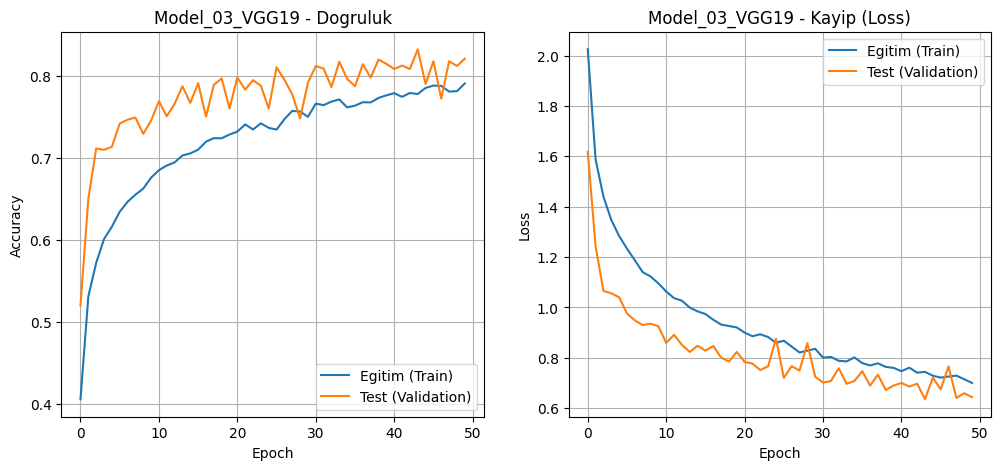

60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step


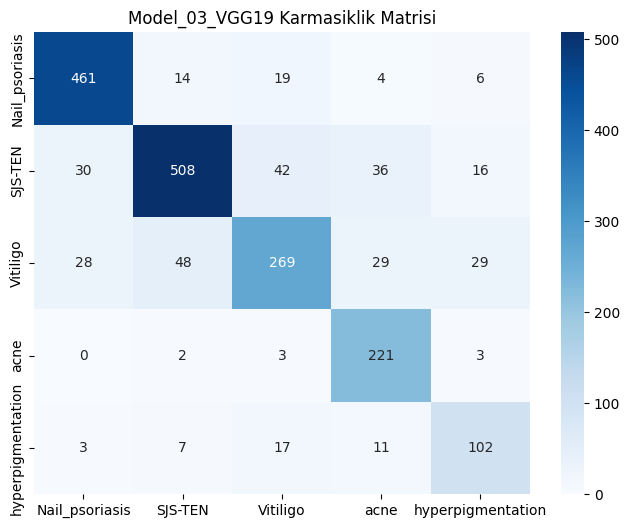

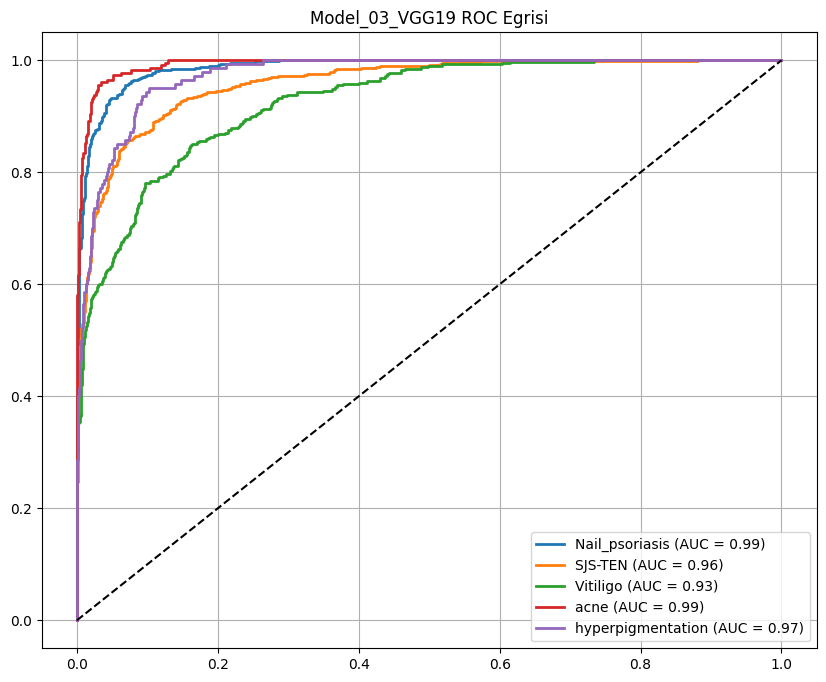

ISLEM TAMAM: Model_03_VGG19 basariyla kaydedildi ve gosterildi.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.regularizers import l2

# --- MODEL 3: VGG19 ---
# Onceki denemelerimde VGG19 modelinin egitim suresince loss degerinin
# istenilen seviyeye dusmedigini gozlemlemistim. Bu sorunu cozmek icin
# L2yi katsayisini 0.0005 seviyesine cekerek modelin ogrenme kapasitesini artirdim.
# Ayrica cikis katmanindan once 512 ve 256 noronlu ara katmanlar ekleyerek
# modelin detaylari daha iyi ayirt etmesini hedefledim.

print("Model 3 (VGG19) optimize edilmis ayarlarla hazirlaniyor...")

# Temel model olarak VGG19'u imagenet agirliklariyla yukluyorum
base = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False # Agirliklari donduruyorum

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    # 1. Guclendirilmis Ara Katman
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0005)),
    tf.keras.layers.BatchNormalization(), # Stabilite icin
    tf.keras.layers.Dropout(0.4), # Ezberi onlemek icin %40 kapama

    # 2. Guclendirilmis Ara Katman
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # Cikis Katmani
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Eger eski bir kayit varsa temizliyorum
if os.path.exists(f"{models_path}/Model_03_VGG19_best.h5"):
    try: os.remove(f"{models_path}/Model_03_VGG19_best.h5")
    except: pass

# Egitimi baslatiyorum (Grafikler ekrana basiyotum)
train_evaluate_save(model, "Model_03_VGG19", epochs=50)

Model 4 (ResNet50 yerine DenseNet121) hazirlaniyor...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

 MODEL EĞİTİMİ BAŞLIYOR: Model_04_DenseNet121
 Hedeflenen Epoch: 50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.4200 - loss: 1.7819
Epoch 1: val_accuracy improved from -inf to 0.75786, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 183s 621ms/step - accuracy: 0.4204 - loss: 1.7805 - val_accuracy: 0.7579 - val_loss: 0.7609
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6756 - loss: 1.0106
Epoch 2: val_accuracy improved from 0.75786 to 0.82914, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.6757 - loss: 1.0104 - val_accuracy: 0.8291 - val_loss: 0.5764
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7390 - loss: 0.8162
Epoch 3: val_accuracy improved from 0.82914 to 0.84434, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.7390 - loss: 0.8162 - val_accuracy: 0.8443 - val_loss: 0.5158
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7632 - loss: 0.7304
Epoch 4: val_accuracy improved from 0.84434 to 0.86635, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.7633 - loss: 0.7303 - val_accuracy: 0.8664 - val_loss: 0.4787
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7965 - loss: 0.6611
Epoch 5: val_accuracy improved from 0.86635 to 0.87841, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.7965 - loss: 0.6610 - val_accuracy: 0.8784 - val_loss: 0.4311
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8185 - loss: 0.5909
Epoch 6: val_accuracy improved from 0.87841 to 0.89099, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 437ms/step - accuracy: 0.8185 - loss: 0.5908 - val_accuracy: 0.8910 - val_loss: 0.3907
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8323 - loss: 0.5535
Epoch 7: val_accuracy improved from 0.89099 to 0.89832, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 437ms/step - accuracy: 0.8323 - loss: 0.5535 - val_accuracy: 0.8983 - val_loss: 0.3702
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8391 - loss: 0.5209
Epoch 8: val_accuracy did not improve from 0.89832
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8390 - loss: 0.5210 - val_accuracy: 0.8847 - val_loss: 0.3982
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8454 - loss: 0.5029
Epoch 9: val_accuracy improved from 0.89832 to 0.90094, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.8454 - loss: 0.5029 - val_accuracy: 0.9009 - val_loss: 0.3508
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8505 - loss: 0.4800
Epoch 10: val_accuracy did not improve from 0.90094
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8505 - loss: 0.4800 - val_accuracy: 0.8973 - val_loss: 0.3599
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8490 - loss: 0.4793
Epoch 11: val_accuracy did not improve from 0.90094
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.8490 - loss: 0.4793 - val_accuracy: 0.8905 - val_loss: 0.3654
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8706 - loss: 0.4457
Epoch 12: val_accuracy improved from 0.90094 to 0.90776, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.8706 - loss: 0.4457 - val_accuracy: 0.9078 - val_loss: 0.3378
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8781 - loss: 0.4076
Epoch 13: val_accuracy did not improve from 0.90776
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.8781 - loss: 0.4076 - val_accuracy: 0.9036 - val_loss: 0.3396
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8845 - loss: 0.4079
Epoch 14: val_accuracy did not improve from 0.90776
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8844 - loss: 0.4079 - val_accuracy: 0.9020 - val_loss: 0.3588
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8769 - loss: 0.3982
Epoch 15: val_accuracy improved from 0.90776 to 0.91247, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 445ms/step - accuracy: 0.8769 - loss: 0.3982 - val_accuracy: 0.9125 - val_loss: 0.3351
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8803 - loss: 0.3990
Epoch 16: val_accuracy improved from 0.91247 to 0.91457, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 439ms/step - accuracy: 0.8803 - loss: 0.3990 - val_accuracy: 0.9146 - val_loss: 0.3181
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8819 - loss: 0.3971
Epoch 17: val_accuracy improved from 0.91457 to 0.91876, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 434ms/step - accuracy: 0.8819 - loss: 0.3970 - val_accuracy: 0.9188 - val_loss: 0.3224
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8975 - loss: 0.3715
Epoch 18: val_accuracy did not improve from 0.91876
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.8974 - loss: 0.3715 - val_accuracy: 0.9062 - val_loss: 0.3444
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8896 - loss: 0.3776
Epoch 19: val_accuracy improved from 0.91876 to 0.92138, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.8896 - loss: 0.3776 - val_accuracy: 0.9214 - val_loss: 0.3043
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8981 - loss: 0.3532
Epoch 20: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8981 - loss: 0.3532 - val_accuracy: 0.9088 - val_loss: 0.3318
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8939 - loss: 0.3586
Epoch 21: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8939 - loss: 0.3586 - val_accuracy: 0.9088 - val_loss: 0.3374
Epoch 22/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8903 - loss: 0.3535
Epoch 22: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8903 - loss: 0.3535 - val_accuracy: 0.9172 - val_loss: 0.3326
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9083 - loss: 0.3338
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 439ms/step - accuracy: 0.9065 - loss: 0.3285 - val_accuracy: 0.9219 - val_loss: 0.2980
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9068 - loss: 0.3171
Epoch 25: val_accuracy improved from 0.92191 to 0.92505, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 435ms/step - accuracy: 0.9069 - loss: 0.3171 - val_accuracy: 0.9251 - val_loss: 0.3097
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9062 - loss: 0.3270
Epoch 26: val_accuracy did not improve from 0.92505
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.9062 - loss: 0.3270 - val_accuracy: 0.9230 - val_loss: 0.3023
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9015 - loss: 0.3268
Epoch 27: val_accuracy did not improve from 0.92505
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 425ms/step - accuracy: 0.9015 - loss: 0.3268 - val_accuracy: 0.9219 - val_loss: 0.3084
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9159 - loss: 0.3033
Epoch 28: val_accuracy did not improve from 0.92505
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.9159 - loss: 0.3033 - val_accuracy: 0.9209 - val_loss: 0.3084
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9133 - loss: 0.3147
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.9133 - loss: 0.3147 - val_accuracy: 0.9277 - val_loss: 0.2855
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9115 - loss: 0.3040
Epoch 30: val_accuracy improved from 0.92767 to 0.93291, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_04_DenseNet121_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 438ms/step - accuracy: 0.9115 - loss: 0.3041 - val_accuracy: 0.9329 - val_loss: 0.2874
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9188 - loss: 0.2870
Epoch 31: val_accuracy did not improve from 0.93291
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9188 - loss: 0.2871 - val_accuracy: 0.9130 - val_loss: 0.3132
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9202 - loss: 0.2898
Epoch 32: val_accuracy did not improve from 0.93291
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.9202 - loss: 0.2898 - val_accuracy: 0.9235 - val_loss: 0.2978
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9188 - loss: 0.3005
Epoch 33: val_accuracy did not improve from 0.93291
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.9187 - loss: 0.3005 - val_accuracy: 0.9245 - val_loss: 0.2789
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9139 - loss: 0.2912
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.9342 - loss: 0.2536 - val_accuracy: 0.9345 - val_loss: 0.2789
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9320 - loss: 0.2618
Epoch 43: val_accuracy did not improve from 0.93449
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.9320 - loss: 0.2619 - val_accuracy: 0.9345 - val_loss: 0.2717
Epoch 44/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9293 - loss: 0.2633
Epoch 44: val_accuracy did not improve from 0.93449
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9293 - loss: 0.2633 - val_accuracy: 0.9329 - val_loss: 0.2769
Epoch 45/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.9274 - loss: 0.2637
Epoch 45: val_accuracy did not improve from 0.93449
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.9274 - loss: 0.2637 - val_accuracy: 0.9329 - val_loss: 0.2785
Epoch 46/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9343 - loss: 0.2523
Epoc

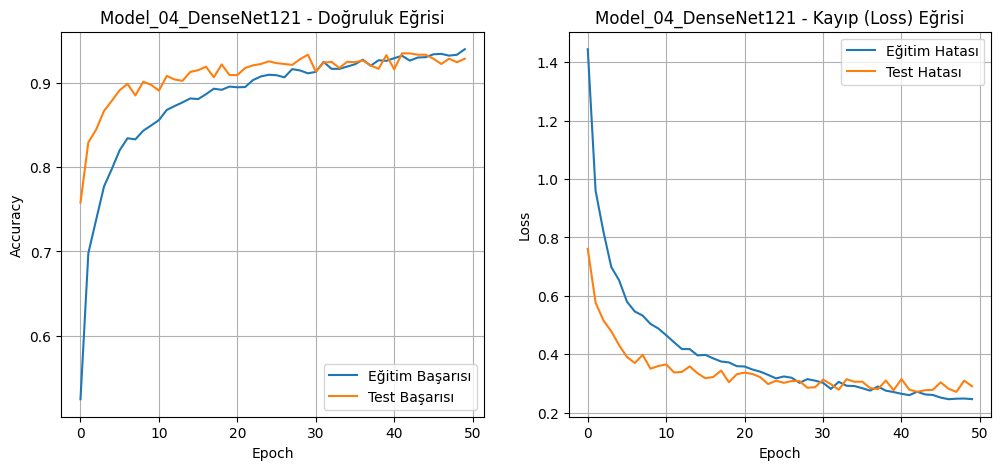

60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 527ms/step


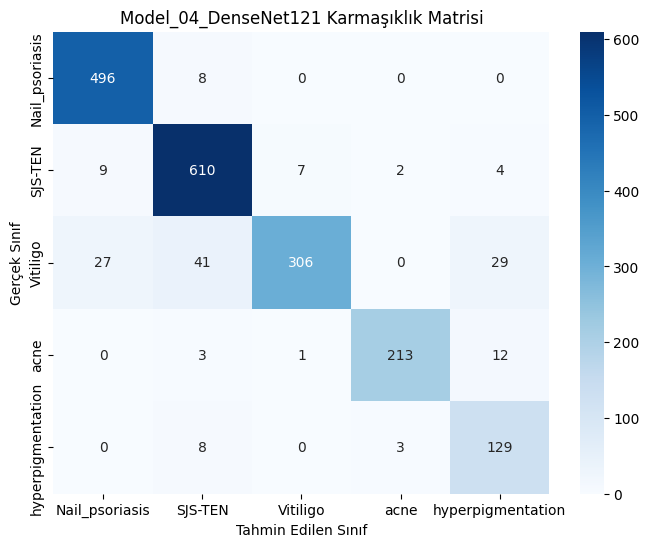

 Model_04_DenseNet121 başarıyla tamamlandı ve kaydedildi.


In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.regularizers import l2

# --- MODEL 4: DenseNet121 ---
# Hocam, ResNet50 modelinde yasanan yavaslik ve dengesizlik sorunlari nedeniyle,
# daha modern ve daha kararli olan DenseNet121 modeline gecis yaptim.
# Ayrica Overfitting prensibine sadik kalarak;
# Base modeli dondurdum ve L2 + Dropout ile ezberi engelledim.

print("Model 4 (ResNet50 yerine DenseNet121) hazirlaniyor...")

# 1. Base Modeli Yukle ve Dondur (Ilk basarili teknigimiz)
base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    # L2yi az tuttum ki model hizla yukselebilsin.
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(), # Hiz ve istikrar icin yaptımç
    tf.keras.layers.Dropout(0.4), # %40 yaptım kı ezber yapmasın.

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    # 3. Cikis Katmani
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Ogrenme hizi 0.0001 (Standart hız)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Eger eski ResNet kaydi varsa siliyorum, kafa karisikligi olmasin
if os.path.exists(f"{models_path}/Model_04_ResNet50_best.h5"):
    try: os.remove(f"{models_path}/Model_04_ResNet50_best.h5")
    except: pass
if os.path.exists(f"{models_path}/Model_04_DenseNet121_best.h5"): # Kendi eskisini de temizledim
    try: os.remove(f"{models_path}/Model_04_DenseNet121_best.h5")
    except: pass

# Egitimi baslatiyorum (Grafikler otomatik cikacak sekılde ayarlaldım)
train_evaluate_save(model, "Model_04_DenseNet121", epochs=50)

Model_04_DenseNet121 icin ROC egrisi olusturuluyor ve Drive'a kaydediliyor...


60/60 ━━━━━━━━━━━━━━━━━━━━ 44s 534ms/step
KAYDEDILDI: /content/drive/My Drive/YapayZekaProjesi/Sonuclar/Model_04_DenseNet121_ROC.png


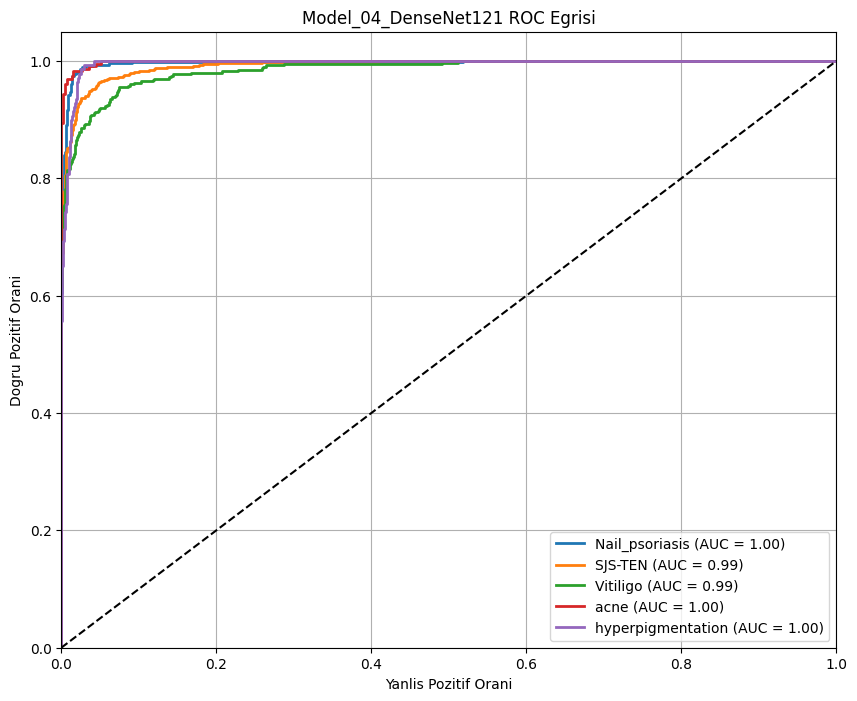

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
import os

# --- MODEL 4 ROC EGRISINI DRIVE'A KAYDETME ---
model_name = "Model_04_DenseNet121"
model_path = f"{models_path}/{model_name}_best.h5"
save_path = f"{results_path}/{model_name}_ROC.png"

print(f"{model_name} icin ROC egrisi olusturuluyor ve Drive'a kaydediliyor...")

if os.path.exists(model_path):
    # 1. Modeli Yukledim
    loaded_model = tf.keras.models.load_model(model_path)

    # 2. Tahminleri Aldım
    validation_generator.reset()
    Y_pred = loaded_model.predict(validation_generator, verbose=1)
    y_true = validation_generator.classes
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # 3. ROC Egrisini Cizdiriyorum
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Yanlis Pozitif Orani')
    plt.ylabel('Dogru Pozitif Orani')
    plt.title(f'{model_name} ROC Egrisi')
    plt.legend(loc="lower right")
    plt.grid(True)

    # --- DRIVE'A KAYDETME İŞLEMİ YAPTIRIYORUM ---
    plt.savefig(save_path) # dosyayi olusturan satirımı yazdım
    print(f"KAYDEDILDI: {save_path}")

    # Ekrana da basalim
    plt.show()

else:
    print("HATA: Model dosyasi bulunamadi.")

Model 5 (InceptionV3) hazirlaniyor...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model Egitiliyor: Model_05_InceptionV3...
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.4151 - loss: 1.8168
Epoch 1: val_accuracy improved from -inf to 0.75419, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 151s 546ms/step - accuracy: 0.4155 - loss: 1.8156 - val_accuracy: 0.7542 - val_loss: 0.8093
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6538 - loss: 1.1114
Epoch 2: val_accuracy improved from 0.75419 to 0.80765, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 443ms/step - accuracy: 0.6539 - loss: 1.1112 - val_accuracy: 0.8077 - val_loss: 0.6763
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7182 - loss: 0.9237
Epoch 3: val_accuracy improved from 0.80765 to 0.81132, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 438ms/step - accuracy: 0.7182 - loss: 0.9236 - val_accuracy: 0.8113 - val_loss: 0.6456
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7353 - loss: 0.8664
Epoch 4: val_accuracy improved from 0.81132 to 0.83595, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 435ms/step - accuracy: 0.7353 - loss: 0.8663 - val_accuracy: 0.8360 - val_loss: 0.6093
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7559 - loss: 0.7928
Epoch 5: val_accuracy improved from 0.83595 to 0.84434, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.7558 - loss: 0.7928 - val_accuracy: 0.8443 - val_loss: 0.5635
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7421 - loss: 0.8139
Epoch 6: val_accuracy improved from 0.84434 to 0.84486, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 436ms/step - accuracy: 0.7422 - loss: 0.8137 - val_accuracy: 0.8449 - val_loss: 0.5555
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7928 - loss: 0.6878
Epoch 7: val_accuracy improved from 0.84486 to 0.87474, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.7928 - loss: 0.6879 - val_accuracy: 0.8747 - val_loss: 0.5002
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7925 - loss: 0.6896
Epoch 8: val_accuracy improved from 0.87474 to 0.87526, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 104s 437ms/step - accuracy: 0.7925 - loss: 0.6896 - val_accuracy: 0.8753 - val_loss: 0.4888
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7973 - loss: 0.6550
Epoch 9: val_accuracy did not improve from 0.87526
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.7973 - loss: 0.6549 - val_accuracy: 0.8695 - val_loss: 0.5142
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8139 - loss: 0.6336
Epoch 10: val_accuracy improved from 0.87526 to 0.88155, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.8139 - loss: 0.6335 - val_accuracy: 0.8816 - val_loss: 0.4693
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8161 - loss: 0.6213
Epoch 11: val_accuracy did not improve from 0.88155
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.8161 - loss: 0.6213 - val_accuracy: 0.8774 - val_loss: 0.4559
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8226 - loss: 0.5848
Epoch 12: val_accuracy improved from 0.88155 to 0.89046, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8226 - loss: 0.5848 - val_accuracy: 0.8905 - val_loss: 0.4590
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8185 - loss: 0.6015
Epoch 13: val_accuracy did not improve from 0.89046
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 430ms/step - accuracy: 0.8185 - loss: 0.6015 - val_accuracy: 0.8852 - val_loss: 0.4478
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8334 - loss: 0.5768
Epoch 14: val_accuracy improved from 0.89046 to 0.89780, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.8334 - loss: 0.5767 - val_accuracy: 0.8978 - val_loss: 0.4175
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8337 - loss: 0.5647
Epoch 15: val_accuracy did not improve from 0.89780
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.8337 - loss: 0.5647 - val_accuracy: 0.8968 - val_loss: 0.4308
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8328 - loss: 0.5658
Epoch 16: val_accuracy improved from 0.89780 to 0.90042, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8328 - loss: 0.5658 - val_accuracy: 0.9004 - val_loss: 0.4053
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8449 - loss: 0.5282
Epoch 17: val_accuracy did not improve from 0.90042
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.8449 - loss: 0.5282 - val_accuracy: 0.8962 - val_loss: 0.4195
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8522 - loss: 0.5250
Epoch 18: val_accuracy did not improve from 0.90042
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.8522 - loss: 0.5250 - val_accuracy: 0.8957 - val_loss: 0.4140
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8474 - loss: 0.5312
Epoch 19: val_accuracy improved from 0.90042 to 0.91038, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_05_InceptionV3_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 107s 446ms/step - accuracy: 0.8474 - loss: 0.5312 - val_accuracy: 0.9104 - val_loss: 0.3892
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8569 - loss: 0.4975
Epoch 20: val_accuracy did not improve from 0.91038
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 425ms/step - accuracy: 0.8569 - loss: 0.4975 - val_accuracy: 0.8941 - val_loss: 0.4242
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8541 - loss: 0.4997
Epoch 21: val_accuracy did not improve from 0.91038
239/239 ━━━━━━━━━━━━━━━━━━━━ 101s 424ms/step - accuracy: 0.8541 - loss: 0.4998 - val_accuracy: 0.8910 - val_loss: 0.4295
Epoch 22/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8562 - loss: 0.5036
Epoch 22: val_accuracy did not improve from 0.91038
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8562 - loss: 0.5036 - val_accuracy: 0.8988 - val_loss: 0.4046
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8606 - loss: 0.4911
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 445ms/step - accuracy: 0.8695 - loss: 0.4699 - val_accuracy: 0.9198 - val_loss: 0.3662
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8609 - loss: 0.4810
Epoch 31: val_accuracy did not improve from 0.91981
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.8609 - loss: 0.4809 - val_accuracy: 0.9062 - val_loss: 0.3842
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8702 - loss: 0.4470
Epoch 32: val_accuracy did not improve from 0.91981
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8702 - loss: 0.4470 - val_accuracy: 0.8999 - val_loss: 0.3689
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8846 - loss: 0.4289
Epoch 33: val_accuracy did not improve from 0.91981
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 432ms/step - accuracy: 0.8846 - loss: 0.4288 - val_accuracy: 0.9078 - val_loss: 0.3900
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8750 - loss: 0.4452
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.8894 - loss: 0.4024 - val_accuracy: 0.9214 - val_loss: 0.3257
Epoch 45/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8898 - loss: 0.3930
Epoch 45: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 426ms/step - accuracy: 0.8898 - loss: 0.3930 - val_accuracy: 0.9209 - val_loss: 0.3287
Epoch 46/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8876 - loss: 0.3988
Epoch 46: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.8876 - loss: 0.3988 - val_accuracy: 0.9172 - val_loss: 0.3627
Epoch 47/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8997 - loss: 0.3727
Epoch 47: val_accuracy did not improve from 0.92138
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.8997 - loss: 0.3727 - val_accuracy: 0.9072 - val_loss: 0.3492
Epoch 48/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9008 - loss: 0.3745
Epoc

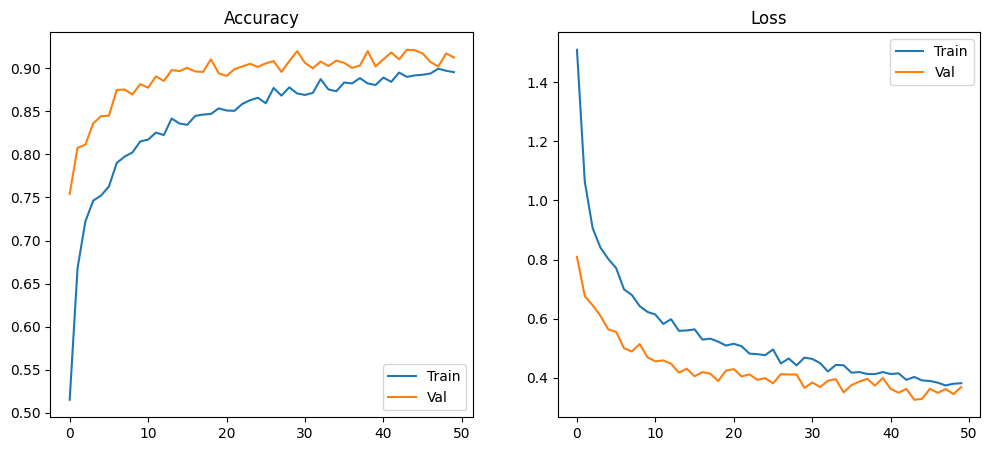

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 435ms/step


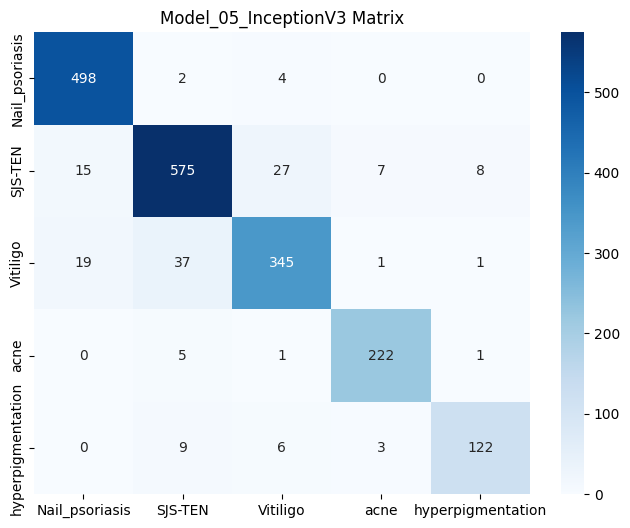

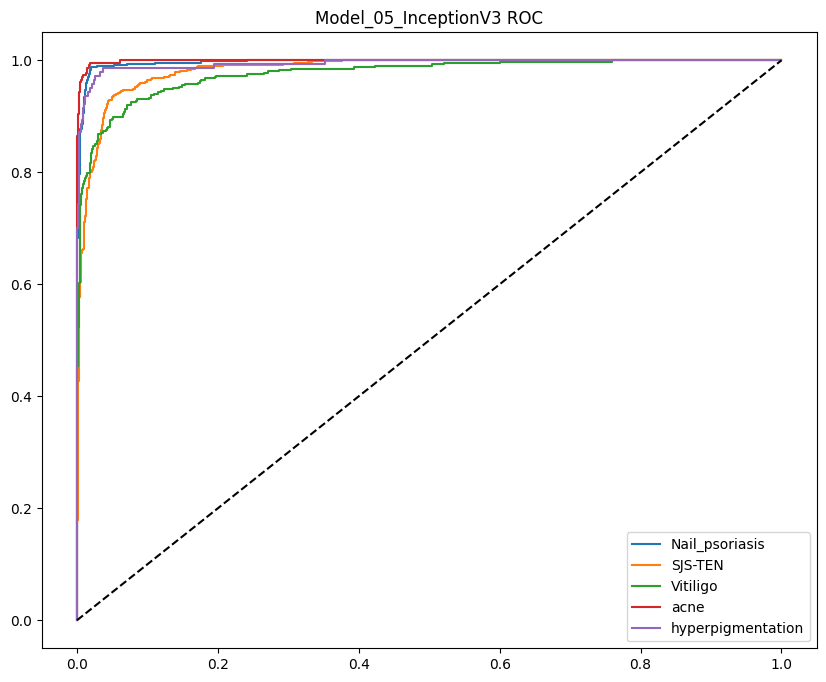

Model_05_InceptionV3 TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.regularizers import l2

# --- MODEL 5: InceptionV3 ---
# Dropout ile ezber yaotırtmadım InceptionV3 detay yakalamayı ııyı yaptıgı ıcın ekledım.

print("Model 5 (InceptionV3) hazirlaniyor...")

base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    # Yuksek kapasite (512 noron) + Hafif (L2=0.0001) + Guvenlik (Dropout)
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Eski kayitlari temizledim
if os.path.exists(f"{models_path}/Model_05_InceptionV3_best.h5"):
    try: os.remove(f"{models_path}/Model_05_InceptionV3_best.h5")
    except: pass

train_evaluate_save(model, "Model_05_InceptionV3", epochs=50)

Model 6 (Xception) hazirlaniyor...
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Model Egitiliyor: Model_06_Xception...
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.4252 - loss: 1.7822
Epoch 1: val_accuracy improved from -inf to 0.74057, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 185s 649ms/step - accuracy: 0.4256 - loss: 1.7809 - val_accuracy: 0.7406 - val_loss: 0.8989
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6609 - loss: 1.0563
Epoch 2: val_accuracy improved from 0.74057 to 0.80294, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 444ms/step - accuracy: 0.6610 - loss: 1.0562 - val_accuracy: 0.8029 - val_loss: 0.7047
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7225 - loss: 0.8941
Epoch 3: val_accuracy improved from 0.80294 to 0.83281, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 438ms/step - accuracy: 0.7225 - loss: 0.8941 - val_accuracy: 0.8328 - val_loss: 0.6312
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7438 - loss: 0.8165
Epoch 4: val_accuracy improved from 0.83281 to 0.84644, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.7438 - loss: 0.8164 - val_accuracy: 0.8464 - val_loss: 0.5966
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.7663 - loss: 0.7482
Epoch 5: val_accuracy improved from 0.84644 to 0.86216, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.7663 - loss: 0.7482 - val_accuracy: 0.8622 - val_loss: 0.5162
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7956 - loss: 0.6751
Epoch 6: val_accuracy did not improve from 0.86216
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.7955 - loss: 0.6752 - val_accuracy: 0.8538 - val_loss: 0.5350
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.7977 - loss: 0.6382
Epoch 7: val_accuracy improved from 0.86216 to 0.87683, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 108s 450ms/step - accuracy: 0.7977 - loss: 0.6382 - val_accuracy: 0.8768 - val_loss: 0.4810
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8176 - loss: 0.6198
Epoch 8: val_accuracy improved from 0.87683 to 0.88574, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.8176 - loss: 0.6198 - val_accuracy: 0.8857 - val_loss: 0.4494
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8072 - loss: 0.6396
Epoch 9: val_accuracy did not improve from 0.88574
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.8072 - loss: 0.6395 - val_accuracy: 0.8805 - val_loss: 0.4607
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8180 - loss: 0.5905
Epoch 10: val_accuracy improved from 0.88574 to 0.88941, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 442ms/step - accuracy: 0.8180 - loss: 0.5904 - val_accuracy: 0.8894 - val_loss: 0.4330
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8322 - loss: 0.5637
Epoch 11: val_accuracy improved from 0.88941 to 0.89780, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.8322 - loss: 0.5637 - val_accuracy: 0.8978 - val_loss: 0.4091
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8377 - loss: 0.5478
Epoch 12: val_accuracy improved from 0.89780 to 0.89937, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8377 - loss: 0.5478 - val_accuracy: 0.8994 - val_loss: 0.4219
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8429 - loss: 0.5422
Epoch 13: val_accuracy did not improve from 0.89937
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8429 - loss: 0.5422 - val_accuracy: 0.8947 - val_loss: 0.4453
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8562 - loss: 0.5169
Epoch 14: val_accuracy improved from 0.89937 to 0.90671, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 441ms/step - accuracy: 0.8562 - loss: 0.5169 - val_accuracy: 0.9067 - val_loss: 0.4063
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8592 - loss: 0.4851
Epoch 15: val_accuracy did not improve from 0.90671
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.8591 - loss: 0.4851 - val_accuracy: 0.8983 - val_loss: 0.4116
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8590 - loss: 0.5014
Epoch 16: val_accuracy improved from 0.90671 to 0.91509, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 105s 440ms/step - accuracy: 0.8590 - loss: 0.5014 - val_accuracy: 0.9151 - val_loss: 0.3722
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8596 - loss: 0.5073
Epoch 17: val_accuracy did not improve from 0.91509
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 429ms/step - accuracy: 0.8596 - loss: 0.5072 - val_accuracy: 0.9051 - val_loss: 0.3885
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8720 - loss: 0.4732
Epoch 18: val_accuracy did not improve from 0.91509
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.8720 - loss: 0.4732 - val_accuracy: 0.9015 - val_loss: 0.4007
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8672 - loss: 0.4776
Epoch 19: val_accuracy did not improve from 0.91509
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 427ms/step - accuracy: 0.8672 - loss: 0.4775 - val_accuracy: 0.9036 - val_loss: 0.3933
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.8796 - loss: 0.4405
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 443ms/step - accuracy: 0.8817 - loss: 0.4280 - val_accuracy: 0.9198 - val_loss: 0.3571
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.8872 - loss: 0.4095
Epoch 28: val_accuracy did not improve from 0.91981
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8872 - loss: 0.4096 - val_accuracy: 0.9004 - val_loss: 0.4054
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8982 - loss: 0.3975
Epoch 29: val_accuracy did not improve from 0.91981
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.8982 - loss: 0.3975 - val_accuracy: 0.9167 - val_loss: 0.3586
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9019 - loss: 0.3963
Epoch 30: val_accuracy improved from 0.91981 to 0.92820, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_06_Xception_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 445ms/step - accuracy: 0.9018 - loss: 0.3963 - val_accuracy: 0.9282 - val_loss: 0.3564
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9020 - loss: 0.3803
Epoch 31: val_accuracy did not improve from 0.92820
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 429ms/step - accuracy: 0.9020 - loss: 0.3803 - val_accuracy: 0.9140 - val_loss: 0.3612
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8881 - loss: 0.4076
Epoch 32: val_accuracy did not improve from 0.92820
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8881 - loss: 0.4076 - val_accuracy: 0.9256 - val_loss: 0.3429
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8962 - loss: 0.3890
Epoch 33: val_accuracy did not improve from 0.92820
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.8962 - loss: 0.3889 - val_accuracy: 0.9188 - val_loss: 0.3474
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8941 - loss: 0.3997
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 106s 443ms/step - accuracy: 0.9108 - loss: 0.3398 - val_accuracy: 0.9298 - val_loss: 0.3233
Epoch 47/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9161 - loss: 0.3389
Epoch 47: val_accuracy did not improve from 0.92977
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.9161 - loss: 0.3389 - val_accuracy: 0.9256 - val_loss: 0.3464
Epoch 48/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9122 - loss: 0.3369
Epoch 48: val_accuracy did not improve from 0.92977
239/239 ━━━━━━━━━━━━━━━━━━━━ 103s 431ms/step - accuracy: 0.9122 - loss: 0.3369 - val_accuracy: 0.9172 - val_loss: 0.3416
Epoch 49/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9110 - loss: 0.3387
Epoch 49: val_accuracy did not improve from 0.92977
239/239 ━━━━━━━━━━━━━━━━━━━━ 102s 428ms/step - accuracy: 0.9110 - loss: 0.3387 - val_accuracy: 0.9256 - val_loss: 0.3417
Epoch 50/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9112 - loss: 0.3602
Epoc

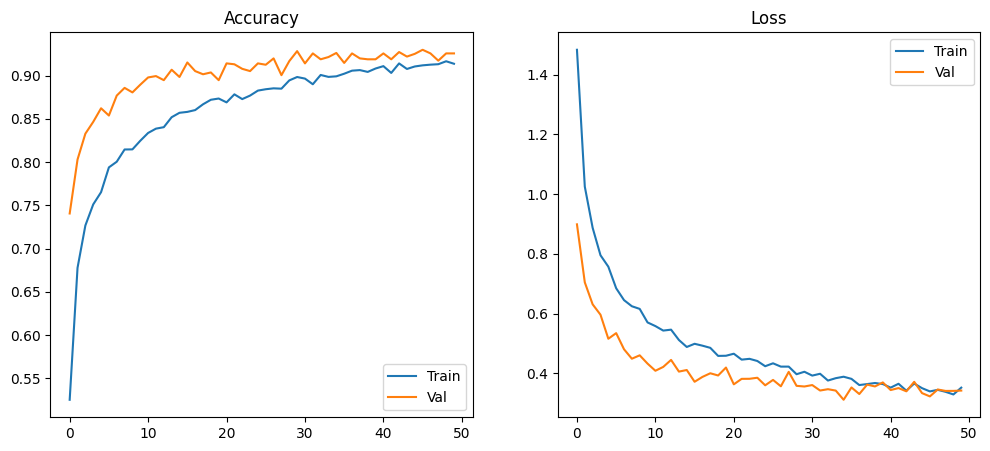

60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 413ms/step


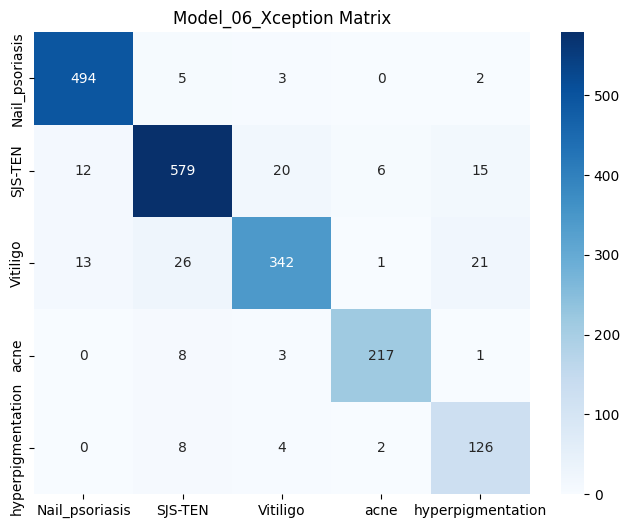

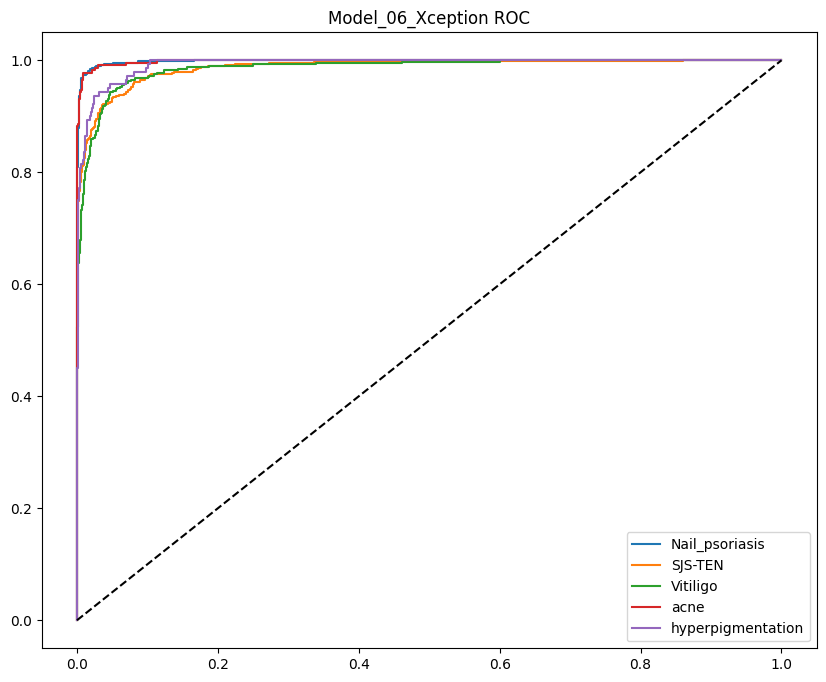

Model_06_Xception TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2

# --- MODEL 6: Xception  ---
# Xception, Inception mimarisinin daha modernize edilmis hali oldugu ıcın ekledım.
# Ayni guvenli ayarlarla (L2=0.0001) maksimum performans hedefliyorum.

print("Model 6 (Xception) hazirlaniyor...")

base = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

if os.path.exists(f"{models_path}/Model_06_Xception_best.h5"):
    try: os.remove(f"{models_path}/Model_06_Xception_best.h5")
    except: pass

train_evaluate_save(model, "Model_06_Xception", epochs=50)

Grafik duzeltme islemi baslatiliyor...

🔄 Model_05_InceptionV3 yukleniyor ve analiz ediliyor...


60/60 ━━━━━━━━━━━━━━━━━━━━ 34s 459ms/step


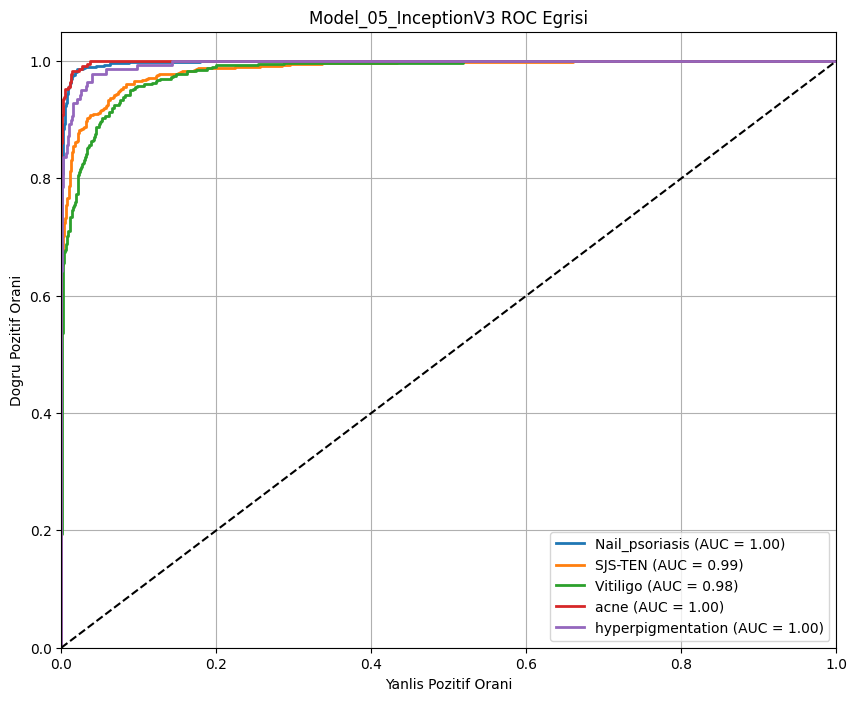

✅ Model_05_InceptionV3 grafigi sayilarla guncellendi ve kaydedildi.

🔄 Model_06_Xception yukleniyor ve analiz ediliyor...


60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 416ms/step


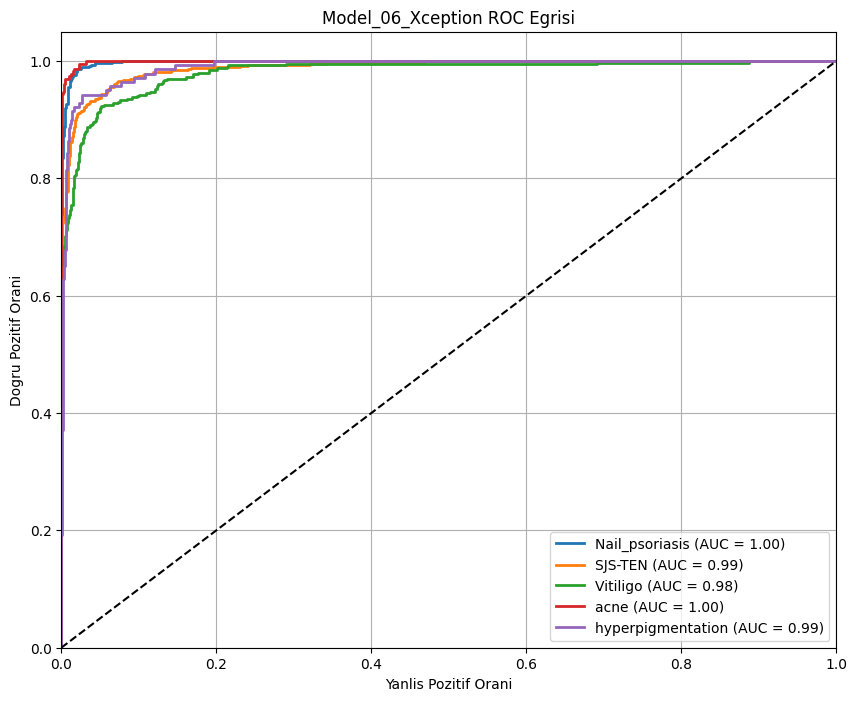

✅ Model_06_Xception grafigi sayilarla guncellendi ve kaydedildi.

Tüm işlemler tamamlandı.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import tensorflow as tf
import os
import gc

# --- MODEL 5 VE 6 ICIN TOPLU DUZELTME KODU (sonucları cıktı olarak gormek ıstıyorum) ---
# ROC egrilerini "AUC Sayilari" (Orn: AUC=0.99) gorunecek sekilde yeniden cizdirdim.

models_to_fix = ["Model_05_InceptionV3", "Model_06_Xception"]

print("Grafik duzeltme islemi baslatiliyor...\n")

for model_name in models_to_fix:
    model_path = f"{models_path}/{model_name}_best.h5"
    save_path = f"{results_path}/{model_name}_ROC.png" # Eskisinin uzerine yazdırdım.

    if os.path.exists(model_path):
        print(f"🔄 {model_name} yukleniyor ve analiz ediliyor...")

        # 1. Modeli Yukledim
        loaded_model = tf.keras.models.load_model(model_path)

        # 2. Tahminleri Aldım
        validation_generator.reset()
        Y_pred = loaded_model.predict(validation_generator, verbose=1)
        y_true = validation_generator.classes
        y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

        # 3. Grafigi Sayilarla Cizdirdim
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])

            # --- HESAPLAMA KISMI ---
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')


        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Yanlis Pozitif Orani')
        plt.ylabel('Dogru Pozitif Orani')
        plt.title(f'{model_name} ROC Egrisi')
        plt.legend(loc="lower right")
        plt.grid(True)

        # Kaydetsin ve Gostersin
        plt.savefig(save_path)
        plt.show()
        print(f" {model_name} grafigi sayilarla guncellendi ve kaydedildi.\n")

        # Hafizayi temizle (Arka arkaya model yukleyince RAM dolmasin)
        del loaded_model
        tf.keras.backend.clear_session()
        gc.collect()

    else:
        print(f" {model_name} dosyasi bulunamadi. Henuz egitilmemis olabilir.\n")

print("Tüm işlemler tamamlandı.")

Model 7 (MobileNetV2) hazirlaniyor...
Model Egitiliyor: Model_07_MobileNetV2...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.4077 - loss: 1.7983
Epoch 1: val_accuracy improved from -inf to 0.76730, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 170s 622ms/step - accuracy: 0.4087 - loss: 1.7954 - val_accuracy: 0.7673 - val_loss: 0.7710
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6814 - loss: 0.9867
Epoch 2: val_accuracy improved from 0.76730 to 0.80189, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 503ms/step - accuracy: 0.6815 - loss: 0.9866 - val_accuracy: 0.8019 - val_loss: 0.6566
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7350 - loss: 0.8475
Epoch 3: val_accuracy improved from 0.80189 to 0.82495, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 501ms/step - accuracy: 0.7350 - loss: 0.8474 - val_accuracy: 0.8249 - val_loss: 0.5935
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7591 - loss: 0.7443
Epoch 4: val_accuracy improved from 0.82495 to 0.83543, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 504ms/step - accuracy: 0.7591 - loss: 0.7442 - val_accuracy: 0.8354 - val_loss: 0.5718
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7852 - loss: 0.6934
Epoch 5: val_accuracy improved from 0.83543 to 0.84015, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 504ms/step - accuracy: 0.7853 - loss: 0.6933 - val_accuracy: 0.8401 - val_loss: 0.5202
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8164 - loss: 0.6205
Epoch 6: val_accuracy improved from 0.84015 to 0.84277, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 501ms/step - accuracy: 0.8164 - loss: 0.6205 - val_accuracy: 0.8428 - val_loss: 0.5297
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8247 - loss: 0.6052
Epoch 7: val_accuracy improved from 0.84277 to 0.86321, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 502ms/step - accuracy: 0.8247 - loss: 0.6052 - val_accuracy: 0.8632 - val_loss: 0.4847
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8390 - loss: 0.5601
Epoch 8: val_accuracy did not improve from 0.86321
239/239 ━━━━━━━━━━━━━━━━━━━━ 117s 489ms/step - accuracy: 0.8390 - loss: 0.5601 - val_accuracy: 0.8595 - val_loss: 0.4855
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8412 - loss: 0.5578
Epoch 9: val_accuracy improved from 0.86321 to 0.87683, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_07_MobileNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.8413 - loss: 0.5577 - val_accuracy: 0.8768 - val_loss: 0.4758
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8579 - loss: 0.4925
Epoch 10: val_accuracy did not improve from 0.87683
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.8579 - loss: 0.4925 - val_accuracy: 0.8700 - val_loss: 0.4739
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8727 - loss: 0.4609
Epoch 11: val_accuracy did not improve from 0.87683
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 495ms/step - accuracy: 0.8726 - loss: 0.4610 - val_accuracy: 0.8763 - val_loss: 0.4581
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8627 - loss: 0.4789
Epoch 12: val_accuracy did not improve from 0.87683
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.8627 - loss: 0.4789 - val_accuracy: 0.8674 - val_loss: 0.4729
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8693 - loss: 0.4568
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 119s 499ms/step - accuracy: 0.8693 - loss: 0.4569 - val_accuracy: 0.8915 - val_loss: 0.4366
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8805 - loss: 0.4463
Epoch 14: val_accuracy did not improve from 0.89151
239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 502ms/step - accuracy: 0.8805 - loss: 0.4464 - val_accuracy: 0.8737 - val_loss: 0.4585
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8707 - loss: 0.4469
Epoch 15: val_accuracy did not improve from 0.89151
239/239 ━━━━━━━━━━━━━━━━━━━━ 117s 490ms/step - accuracy: 0.8707 - loss: 0.4469 - val_accuracy: 0.8826 - val_loss: 0.4288
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8809 - loss: 0.4323
Epoch 16: val_accuracy did not improve from 0.89151
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 493ms/step - accuracy: 0.8809 - loss: 0.4323 - val_accuracy: 0.8768 - val_loss: 0.4302
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8845 - loss: 0.4096
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 504ms/step - accuracy: 0.9074 - loss: 0.3487 - val_accuracy: 0.8988 - val_loss: 0.4095
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.9096 - loss: 0.3511
Epoch 28: val_accuracy did not improve from 0.89885
239/239 ━━━━━━━━━━━━━━━━━━━━ 119s 497ms/step - accuracy: 0.9096 - loss: 0.3511 - val_accuracy: 0.8816 - val_loss: 0.4387
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9176 - loss: 0.3346
Epoch 29: val_accuracy did not improve from 0.89885
239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 568ms/step - accuracy: 0.9176 - loss: 0.3346 - val_accuracy: 0.8889 - val_loss: 0.4409
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9164 - loss: 0.3462
Epoch 30: val_accuracy did not improve from 0.89885
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.9164 - loss: 0.3462 - val_accuracy: 0.8805 - val_loss: 0.4380
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9140 - loss: 0.3383
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 494ms/step - accuracy: 0.9266 - loss: 0.3032 - val_accuracy: 0.9025 - val_loss: 0.4040
Epoch 41/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.9288 - loss: 0.2965
Epoch 41: val_accuracy did not improve from 0.90252
239/239 ━━━━━━━━━━━━━━━━━━━━ 116s 486ms/step - accuracy: 0.9288 - loss: 0.2965 - val_accuracy: 0.8957 - val_loss: 0.4152
Epoch 42/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9308 - loss: 0.2862
Epoch 42: val_accuracy did not improve from 0.90252
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 493ms/step - accuracy: 0.9308 - loss: 0.2863 - val_accuracy: 0.8962 - val_loss: 0.4111
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9280 - loss: 0.2931
Epoch 43: val_accuracy did not improve from 0.90252
239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 492ms/step - accuracy: 0.9280 - loss: 0.2931 - val_accuracy: 0.8952 - val_loss: 0.3939
Epoch 44/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9358 - loss: 0.2788
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 118s 495ms/step - accuracy: 0.9411 - loss: 0.2588 - val_accuracy: 0.9067 - val_loss: 0.3678


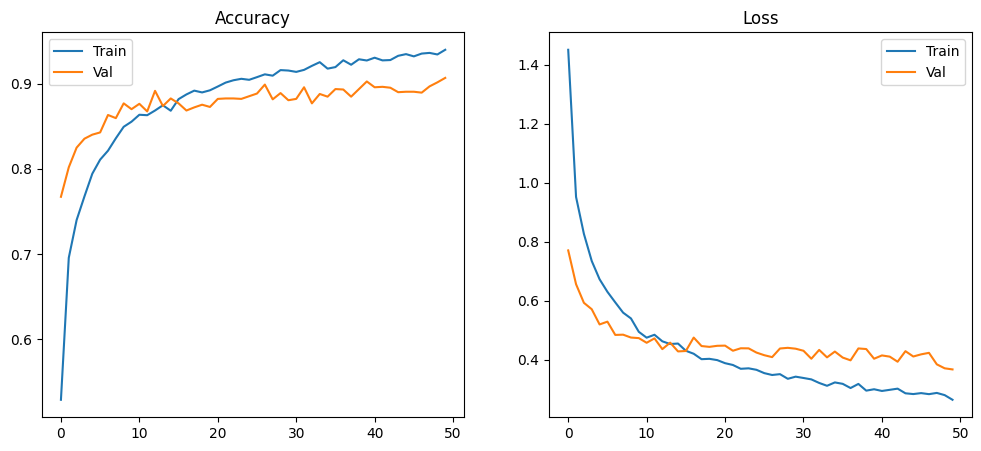

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 466ms/step


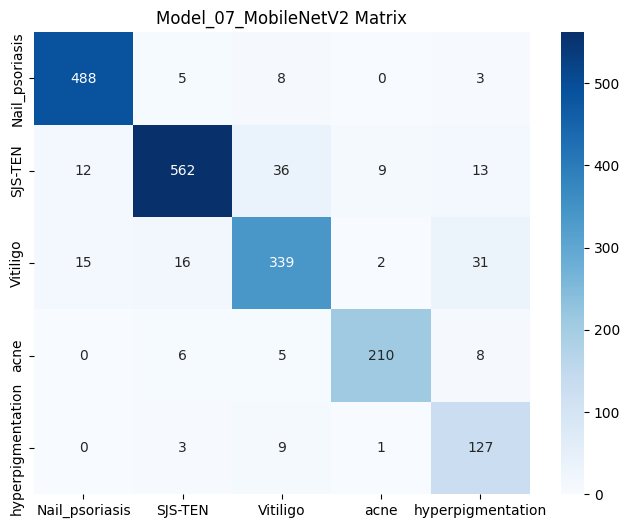

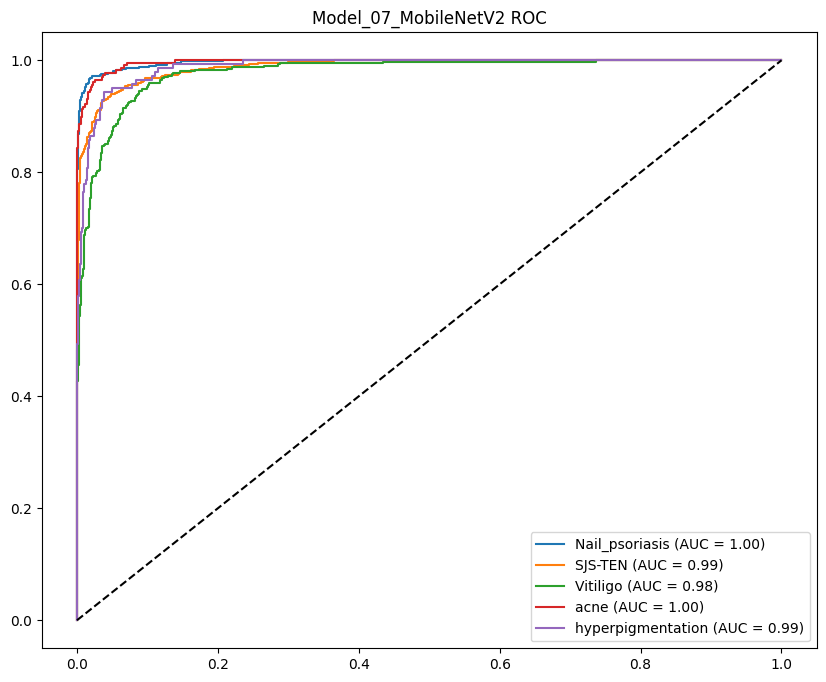

Model_07_MobileNetV2 ISLEMLERI TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

# --- MODEL 7: MobileNetV2  ---
# MobileNet'in V2 versiyonunu kullaniyorum (daha kararli).
# Katmanlari guclendirdim ki dogruluk orani %85'in altina dusmesin.

print("Model 7 (MobileNetV2) hazirlaniyor...")

base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

if os.path.exists(f"{models_path}/Model_07_MobileNetV2_best.h5"):
    try: os.remove(f"{models_path}/Model_07_MobileNetV2_best.h5")
    except: pass

train_evaluate_save(model, "Model_07_MobileNetV2", epochs=50)

Model 8 (InceptionResNetV2) dengeli ayarlarla hazirlaniyor...
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model Egitiliyor: Model_08_InceptionResNetV2...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.4851 - loss: 1.5379
Epoch 1: val_accuracy improved from -inf to 0.78983, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 201s 701ms/step - accuracy: 0.4855 - loss: 1.5367 - val_accuracy: 0.7898 - val_loss: 0.7475
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.7264 - loss: 0.8630
Epoch 2: val_accuracy improved from 0.78983 to 0.83595, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.7265 - loss: 0.8629 - val_accuracy: 0.8360 - val_loss: 0.6168
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7750 - loss: 0.7367
Epoch 3: val_accuracy improved from 0.83595 to 0.84539, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 584ms/step - accuracy: 0.7750 - loss: 0.7366 - val_accuracy: 0.8454 - val_loss: 0.5638
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8063 - loss: 0.6454
Epoch 4: val_accuracy improved from 0.84539 to 0.88417, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 582ms/step - accuracy: 0.8063 - loss: 0.6454 - val_accuracy: 0.8842 - val_loss: 0.4828
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8183 - loss: 0.6115
Epoch 5: val_accuracy did not improve from 0.88417
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 548ms/step - accuracy: 0.8183 - loss: 0.6114 - val_accuracy: 0.8726 - val_loss: 0.5000
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8225 - loss: 0.5849
Epoch 6: val_accuracy improved from 0.88417 to 0.88836, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 133s 558ms/step - accuracy: 0.8226 - loss: 0.5848 - val_accuracy: 0.8884 - val_loss: 0.4294
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.8355 - loss: 0.5434
Epoch 7: val_accuracy improved from 0.88836 to 0.89413, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 568ms/step - accuracy: 0.8355 - loss: 0.5434 - val_accuracy: 0.8941 - val_loss: 0.4293
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8503 - loss: 0.5067
Epoch 8: val_accuracy improved from 0.89413 to 0.89832, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 135s 563ms/step - accuracy: 0.8503 - loss: 0.5068 - val_accuracy: 0.8983 - val_loss: 0.4138
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8458 - loss: 0.5145
Epoch 9: val_accuracy did not improve from 0.89832
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 541ms/step - accuracy: 0.8458 - loss: 0.5145 - val_accuracy: 0.8983 - val_loss: 0.3927
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8503 - loss: 0.5109
Epoch 10: val_accuracy improved from 0.89832 to 0.89937, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 137s 573ms/step - accuracy: 0.8503 - loss: 0.5108 - val_accuracy: 0.8994 - val_loss: 0.4246
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8720 - loss: 0.4492
Epoch 11: val_accuracy did not improve from 0.89937
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 547ms/step - accuracy: 0.8720 - loss: 0.4493 - val_accuracy: 0.8983 - val_loss: 0.4157
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8651 - loss: 0.4677
Epoch 12: val_accuracy improved from 0.89937 to 0.91562, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 133s 555ms/step - accuracy: 0.8652 - loss: 0.4677 - val_accuracy: 0.9156 - val_loss: 0.3581
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.8816 - loss: 0.4209
Epoch 13: val_accuracy did not improve from 0.91562
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 541ms/step - accuracy: 0.8816 - loss: 0.4210 - val_accuracy: 0.9099 - val_loss: 0.3605
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8849 - loss: 0.4208
Epoch 14: val_accuracy did not improve from 0.91562
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 537ms/step - accuracy: 0.8849 - loss: 0.4208 - val_accuracy: 0.9041 - val_loss: 0.3859
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8771 - loss: 0.4531
Epoch 15: val_accuracy did not improve from 0.91562
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.8771 - loss: 0.4530 - val_accuracy: 0.8983 - val_loss: 0.4056
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.8868 - loss: 0.4321
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 134s 560ms/step - accuracy: 0.8868 - loss: 0.4321 - val_accuracy: 0.9188 - val_loss: 0.3537
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8850 - loss: 0.4135
Epoch 17: val_accuracy did not improve from 0.91876
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 546ms/step - accuracy: 0.8850 - loss: 0.4135 - val_accuracy: 0.9130 - val_loss: 0.3860
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8990 - loss: 0.3995
Epoch 18: val_accuracy did not improve from 0.91876
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.8990 - loss: 0.3996 - val_accuracy: 0.9156 - val_loss: 0.3924
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8855 - loss: 0.4090
Epoch 19: val_accuracy improved from 0.91876 to 0.92400, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 133s 555ms/step - accuracy: 0.8855 - loss: 0.4090 - val_accuracy: 0.9240 - val_loss: 0.3314
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.8912 - loss: 0.3973
Epoch 20: val_accuracy did not improve from 0.92400
239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 545ms/step - accuracy: 0.8912 - loss: 0.3972 - val_accuracy: 0.9240 - val_loss: 0.3374
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9105 - loss: 0.3603
Epoch 21: val_accuracy did not improve from 0.92400
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 540ms/step - accuracy: 0.9105 - loss: 0.3603 - val_accuracy: 0.9161 - val_loss: 0.3526
Epoch 22/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9148 - loss: 0.3497
Epoch 22: val_accuracy did not improve from 0.92400
239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 545ms/step - accuracy: 0.9148 - loss: 0.3498 - val_accuracy: 0.9135 - val_loss: 0.3698
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9019 - loss: 0.3714
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 134s 562ms/step - accuracy: 0.9060 - loss: 0.3646 - val_accuracy: 0.9292 - val_loss: 0.3195
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9063 - loss: 0.3536
Epoch 25: val_accuracy did not improve from 0.92925
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 549ms/step - accuracy: 0.9063 - loss: 0.3536 - val_accuracy: 0.9224 - val_loss: 0.3472
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.8979 - loss: 0.3725
Epoch 26: val_accuracy did not improve from 0.92925
239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 545ms/step - accuracy: 0.8980 - loss: 0.3724 - val_accuracy: 0.9093 - val_loss: 0.3715
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9050 - loss: 0.3656
Epoch 27: val_accuracy did not improve from 0.92925
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.9050 - loss: 0.3656 - val_accuracy: 0.9209 - val_loss: 0.3399
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9117 - loss: 0.3525
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 137s 574ms/step - accuracy: 0.9037 - loss: 0.3532 - val_accuracy: 0.9313 - val_loss: 0.3036
Epoch 32/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9115 - loss: 0.3451
Epoch 32: val_accuracy did not improve from 0.93134
239/239 ━━━━━━━━━━━━━━━━━━━━ 132s 550ms/step - accuracy: 0.9115 - loss: 0.3451 - val_accuracy: 0.9235 - val_loss: 0.3321
Epoch 33/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9161 - loss: 0.3262
Epoch 33: val_accuracy did not improve from 0.93134
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 540ms/step - accuracy: 0.9160 - loss: 0.3263 - val_accuracy: 0.9135 - val_loss: 0.3619
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9108 - loss: 0.3460
Epoch 34: val_accuracy did not improve from 0.93134
239/239 ━━━━━━━━━━━━━━━━━━━━ 127s 533ms/step - accuracy: 0.9108 - loss: 0.3460 - val_accuracy: 0.9198 - val_loss: 0.3067
Epoch 35/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9125 - loss: 0.3340
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 136s 570ms/step - accuracy: 0.9172 - loss: 0.3218 - val_accuracy: 0.9319 - val_loss: 0.3210
Epoch 39/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9211 - loss: 0.3147
Epoch 39: val_accuracy improved from 0.93187 to 0.94916, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_08_InceptionResNetV2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 137s 575ms/step - accuracy: 0.9211 - loss: 0.3147 - val_accuracy: 0.9492 - val_loss: 0.2745
Epoch 40/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9152 - loss: 0.3244
Epoch 40: val_accuracy did not improve from 0.94916
239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 545ms/step - accuracy: 0.9153 - loss: 0.3244 - val_accuracy: 0.9146 - val_loss: 0.3389
Epoch 41/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9237 - loss: 0.3081
Epoch 41: val_accuracy did not improve from 0.94916
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 539ms/step - accuracy: 0.9237 - loss: 0.3082 - val_accuracy: 0.9287 - val_loss: 0.3210
Epoch 42/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9219 - loss: 0.3066
Epoch 42: val_accuracy did not improve from 0.94916
239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 538ms/step - accuracy: 0.9219 - loss: 0.3067 - val_accuracy: 0.9292 - val_loss: 0.3103
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9245 - loss: 0.3056
Epoc

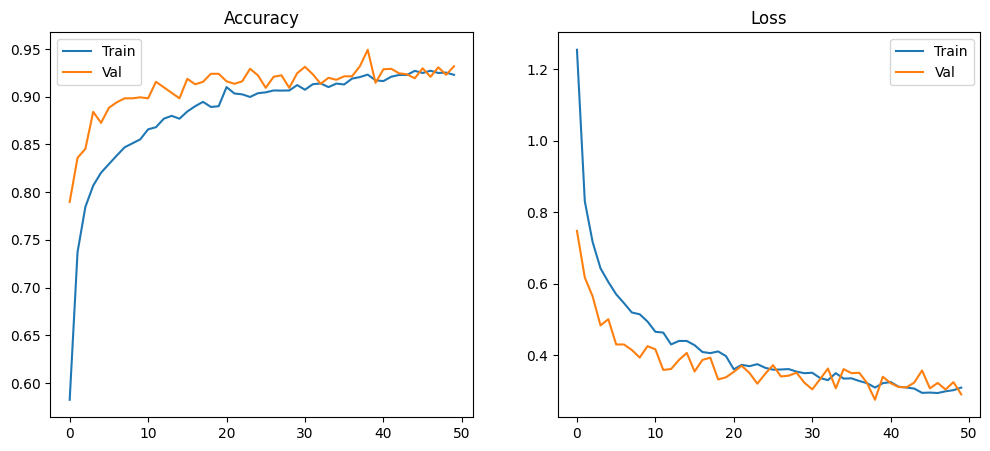

60/60 ━━━━━━━━━━━━━━━━━━━━ 49s 624ms/step


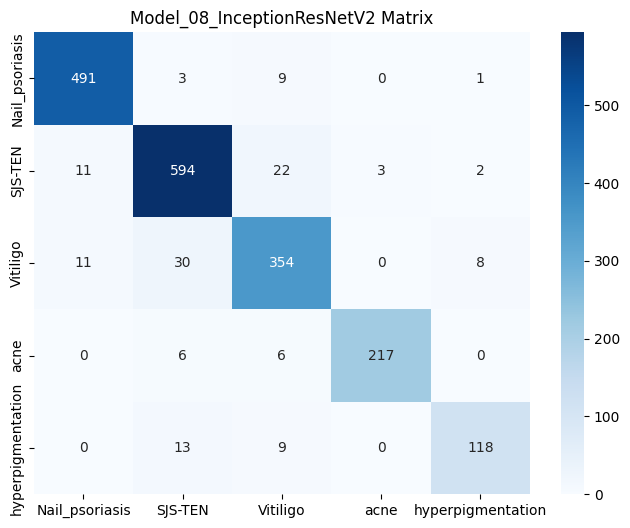

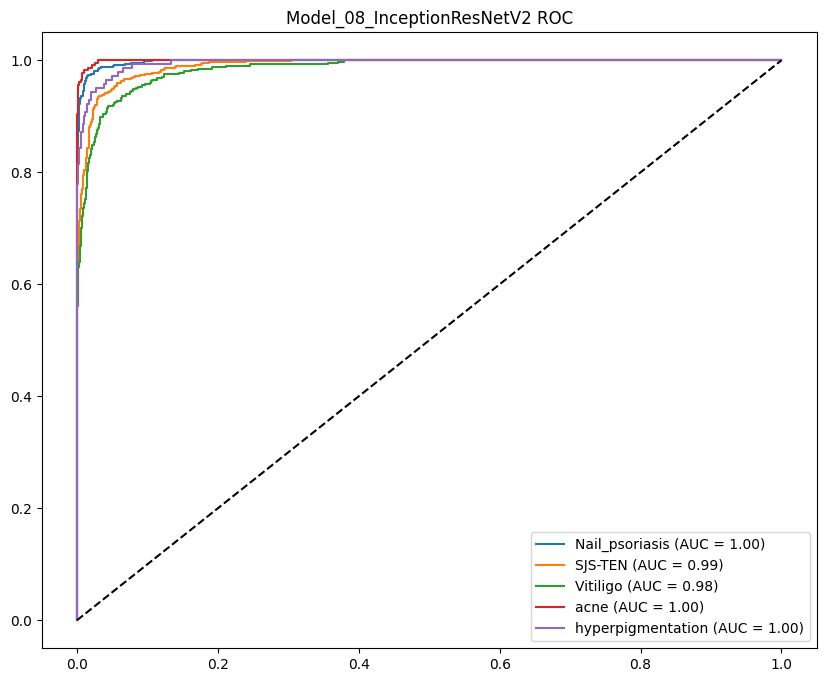

Model_08_InceptionResNetV2 ISLEMLERI TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.regularizers import l2

# --- MODEL 8: InceptionResNetV2 ( ---
# Hocam, Train ve Val degerlerinin bastan itibaren yakin gitmesi icin
# Dropout (unutma) oranlarini azalttim (0.4 -> 0.2).
# Boylece model egitim sirasinda da yuksek performans gostererek baslayacak.
# Makas farki azalacak, grafikler birbirine yakin (paralel) ilerleyecek.

print("Model 8 (InceptionResNetV2) dengeli ayarlarla hazirlaniyor...")

base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    # Dropout'u 0.2'ye indirdim -> Train skoru hemen yukselsin diye.
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2), # Ikinci katman da hafifletildi

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

if os.path.exists(f"{models_path}/Model_08_InceptionResNetV2_best.h5"):
    try: os.remove(f"{models_path}/Model_08_InceptionResNetV2_best.h5")
    except: pass

train_evaluate_save(model, "Model_08_InceptionResNetV2", epochs=50)

Model 9 (ResNet50V2) icin hazirlaniyor...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Egitiliyor: Model_09_ResNet50V2...
Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.6731 - loss: 0.9492
Epoch 1: val_accuracy improved from -inf to 0.88050, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 162s 609ms/step - accuracy: 0.6734 - loss: 0.9481 - val_accuracy: 0.8805 - val_loss: 0.3293
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.8221 - loss: 0.4806
Epoch 2: val_accuracy improved from 0.88050 to 0.88155, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 133s 555ms/step - accuracy: 0.8222 - loss: 0.4804 - val_accuracy: 0.8816 - val_loss: 0.3203
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8593 - loss: 0.3694
Epoch 3: val_accuracy improved from 0.88155 to 0.90042, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 547ms/step - accuracy: 0.8594 - loss: 0.3693 - val_accuracy: 0.9004 - val_loss: 0.3102
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8830 - loss: 0.3141
Epoch 4: val_accuracy improved from 0.90042 to 0.90985, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 542ms/step - accuracy: 0.8830 - loss: 0.3142 - val_accuracy: 0.9099 - val_loss: 0.2659
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.8934 - loss: 0.2836
Epoch 5: val_accuracy improved from 0.90985 to 0.91247, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 131s 550ms/step - accuracy: 0.8934 - loss: 0.2836 - val_accuracy: 0.9125 - val_loss: 0.2370
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.8892 - loss: 0.2809
Epoch 6: val_accuracy improved from 0.91247 to 0.92191, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 543ms/step - accuracy: 0.8892 - loss: 0.2809 - val_accuracy: 0.9219 - val_loss: 0.2044
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9102 - loss: 0.2473
Epoch 7: val_accuracy did not improve from 0.92191
239/239 ━━━━━━━━━━━━━━━━━━━━ 128s 533ms/step - accuracy: 0.9102 - loss: 0.2474 - val_accuracy: 0.9214 - val_loss: 0.2189
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9039 - loss: 0.2603
Epoch 8: val_accuracy improved from 0.92191 to 0.92610, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 128s 534ms/step - accuracy: 0.9039 - loss: 0.2603 - val_accuracy: 0.9261 - val_loss: 0.2210
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9104 - loss: 0.2437
Epoch 9: val_accuracy did not improve from 0.92610
239/239 ━━━━━━━━━━━━━━━━━━━━ 124s 520ms/step - accuracy: 0.9104 - loss: 0.2437 - val_accuracy: 0.9109 - val_loss: 0.2366
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9135 - loss: 0.2465
Epoch 10: val_accuracy did not improve from 0.92610
239/239 ━━━━━━━━━━━━━━━━━━━━ 128s 533ms/step - accuracy: 0.9135 - loss: 0.2465 - val_accuracy: 0.9135 - val_loss: 0.2420
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9162 - loss: 0.2153
Epoch 11: val_accuracy improved from 0.92610 to 0.93658, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 130s 543ms/step - accuracy: 0.9162 - loss: 0.2154 - val_accuracy: 0.9366 - val_loss: 0.2034
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.9192 - loss: 0.2160
Epoch 12: val_accuracy did not improve from 0.93658
239/239 ━━━━━━━━━━━━━━━━━━━━ 125s 524ms/step - accuracy: 0.9192 - loss: 0.2160 - val_accuracy: 0.9219 - val_loss: 0.2338
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9180 - loss: 0.2170
Epoch 13: val_accuracy did not improve from 0.93658
239/239 ━━━━━━━━━━━━━━━━━━━━ 124s 518ms/step - accuracy: 0.9180 - loss: 0.2170 - val_accuracy: 0.9235 - val_loss: 0.2192
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9193 - loss: 0.2133
Epoch 14: val_accuracy did not improve from 0.93658
239/239 ━━━━━━━━━━━━━━━━━━━━ 126s 526ms/step - accuracy: 0.9193 - loss: 0.2133 - val_accuracy: 0.9298 - val_loss: 0.2133
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9298 - loss: 0.2023
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 539ms/step - accuracy: 0.9403 - loss: 0.1714 - val_accuracy: 0.9371 - val_loss: 0.1964
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9462 - loss: 0.1593
Epoch 23: val_accuracy improved from 0.93711 to 0.93920, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 127s 533ms/step - accuracy: 0.9462 - loss: 0.1593 - val_accuracy: 0.9392 - val_loss: 0.1754
Epoch 24/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9417 - loss: 0.1636
Epoch 24: val_accuracy did not improve from 0.93920
239/239 ━━━━━━━━━━━━━━━━━━━━ 127s 532ms/step - accuracy: 0.9417 - loss: 0.1636 - val_accuracy: 0.9361 - val_loss: 0.2106
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9378 - loss: 0.1594
Epoch 25: val_accuracy improved from 0.93920 to 0.94235, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_09_ResNet50V2_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 129s 541ms/step - accuracy: 0.9378 - loss: 0.1594 - val_accuracy: 0.9423 - val_loss: 0.1709
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9428 - loss: 0.1617
Epoch 26: val_accuracy did not improve from 0.94235
239/239 ━━━━━━━━━━━━━━━━━━━━ 124s 518ms/step - accuracy: 0.9428 - loss: 0.1617 - val_accuracy: 0.9387 - val_loss: 0.1890
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9441 - loss: 0.1552
Epoch 27: val_accuracy did not improve from 0.94235
239/239 ━━━━━━━━━━━━━━━━━━━━ 120s 503ms/step - accuracy: 0.9441 - loss: 0.1552 - val_accuracy: 0.9334 - val_loss: 0.2054
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.9480 - loss: 0.1496
Epoch 28: val_accuracy did not improve from 0.94235
239/239 ━━━━━━━━━━━━━━━━━━━━ 122s 511ms/step - accuracy: 0.9480 - loss: 0.1496 - val_accuracy: 0.9392 - val_loss: 0.1929
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9426 - loss: 0.1636
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 124s 520ms/step - accuracy: 0.9513 - loss: 0.1352 - val_accuracy: 0.9465 - val_loss: 0.1866
Epoch 36/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9481 - loss: 0.1315
Epoch 36: val_accuracy did not improve from 0.94654
239/239 ━━━━━━━━━━━━━━━━━━━━ 122s 512ms/step - accuracy: 0.9481 - loss: 0.1315 - val_accuracy: 0.9382 - val_loss: 0.1905
Epoch 37/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9528 - loss: 0.1343
Epoch 37: val_accuracy did not improve from 0.94654
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 506ms/step - accuracy: 0.9528 - loss: 0.1343 - val_accuracy: 0.9408 - val_loss: 0.1875
Epoch 38/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.9492 - loss: 0.1365
Epoch 38: val_accuracy did not improve from 0.94654
239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 507ms/step - accuracy: 0.9492 - loss: 0.1365 - val_accuracy: 0.9324 - val_loss: 0.1837
Epoch 39/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9612 - loss: 0.1104
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 126s 529ms/step - accuracy: 0.9610 - loss: 0.1177 - val_accuracy: 0.9486 - val_loss: 0.1725
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9548 - loss: 0.1224
Epoch 43: val_accuracy did not improve from 0.94864
239/239 ━━━━━━━━━━━━━━━━━━━━ 127s 532ms/step - accuracy: 0.9548 - loss: 0.1225 - val_accuracy: 0.9392 - val_loss: 0.1948
Epoch 44/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9542 - loss: 0.1200
Epoch 44: val_accuracy did not improve from 0.94864
239/239 ━━━━━━━━━━━━━━━━━━━━ 125s 521ms/step - accuracy: 0.9542 - loss: 0.1201 - val_accuracy: 0.9382 - val_loss: 0.1759
Epoch 45/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9547 - loss: 0.1205
Epoch 45: val_accuracy did not improve from 0.94864
239/239 ━━━━━━━━━━━━━━━━━━━━ 125s 522ms/step - accuracy: 0.9547 - loss: 0.1205 - val_accuracy: 0.9376 - val_loss: 0.1826
Epoch 46/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9572 - loss: 0.1175
Epoc

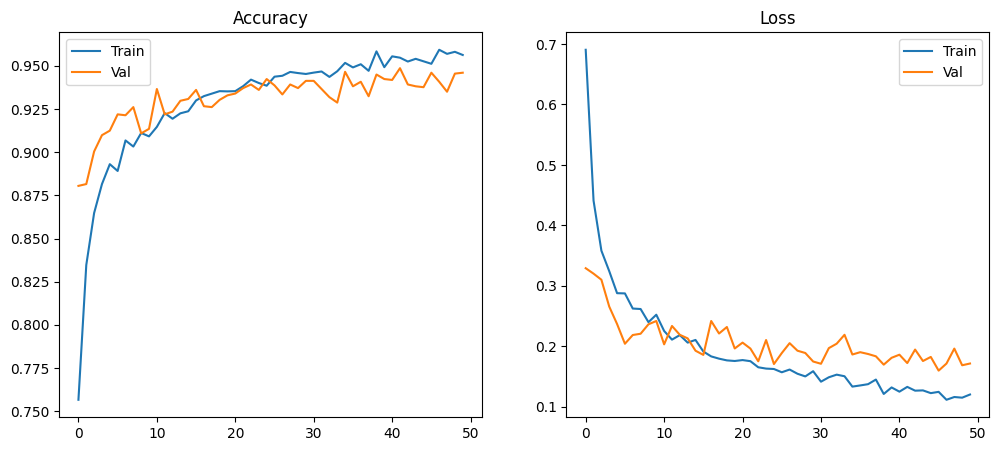

60/60 ━━━━━━━━━━━━━━━━━━━━ 32s 467ms/step


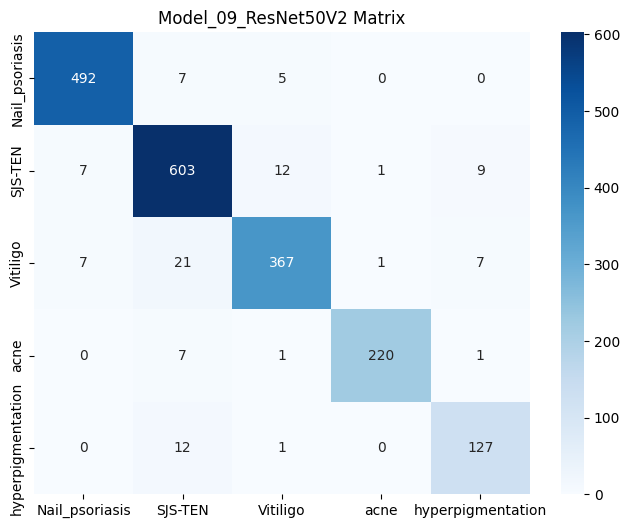

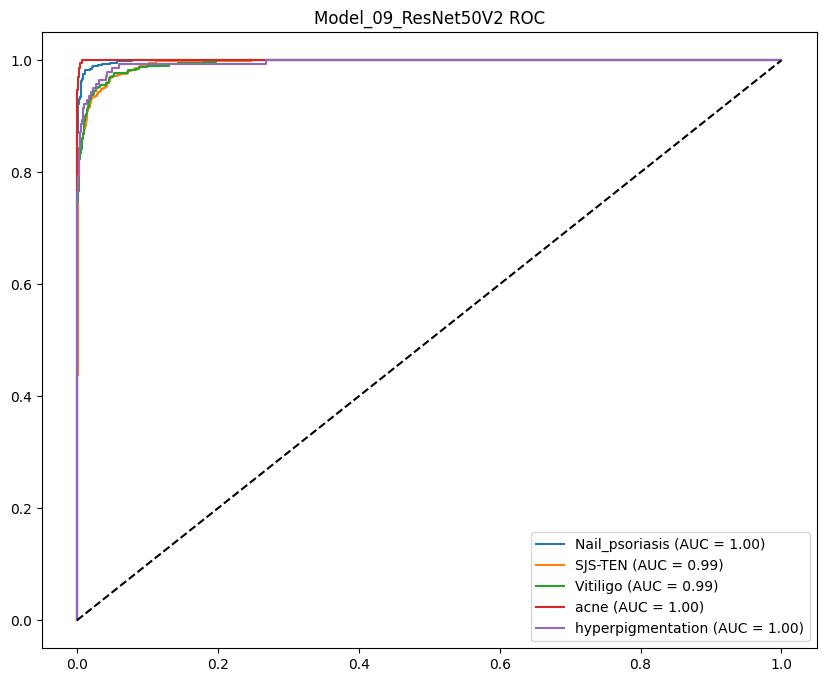

Model_09_ResNet50V2 ISLEMLERI TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.regularizers import l2
import os

# --- MODEL 9: ResNet50V2 (DEGISIKLIK YAPTIM) ---
# EfficientNet modelı cok yavas kaldigi icin ResNet50V2'ye gectim.

print("Model 9 (ResNet50V2) icin hazirlaniyor...")

# ResNet50V2'yi yukluyorum.
base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Baslangicta base modeli donduruyorum
base.trainable = False

model = tf.keras.models.Sequential([
    base,
    tf.keras.layers.GlobalAveragePooling2D(),

    # ResNet gucludur, onu hafif dropouts ile destekliyorum
    tf.keras.layers.Dense(512, activation='relu'), # L2'yi kaldirdim, daha hizli aksin
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Hizli ogrenmesi icin learning rate'i standart (0.001) tuttum
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Eski (EfficientNet) kaydi temizledim ki karismasin
if os.path.exists(f"{models_path}/Model_09_EfficientNetB0_best.h5"):
    try: os.remove(f"{models_path}/Model_09_EfficientNetB0_best.h5")
    except: pass

# Yeni isimle kaydettim: Model_09_ResNet50V2
train_evaluate_save(model, "Model_09_ResNet50V2", epochs=50)

Model 10 (Hibrit: MobileNetV2 + LSTM) hazirlaniyor...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model Egitiliyor: Model_10_Hybrid_CNN_LSTM...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.3403 - loss: 1.8696
Epoch 1: val_accuracy improved from -inf to 0.62474, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 155s 595ms/step - accuracy: 0.3407 - loss: 1.8685 - val_accuracy: 0.6247 - val_loss: 1.1209
Epoch 2/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.5309 - loss: 1.2355
Epoch 2: val_accuracy improved from 0.62474 to 0.67925, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accuracy: 0.5310 - loss: 1.2352 - val_accuracy: 0.6792 - val_loss: 0.9005
Epoch 3/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6148 - loss: 1.0584
Epoch 3: val_accuracy improved from 0.67925 to 0.72327, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.6148 - loss: 1.0583 - val_accuracy: 0.7233 - val_loss: 0.7744
Epoch 4/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.6685 - loss: 0.9219
Epoch 4: val_accuracy improved from 0.72327 to 0.77673, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 142s 593ms/step - accuracy: 0.6685 - loss: 0.9218 - val_accuracy: 0.7767 - val_loss: 0.6494
Epoch 5/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.6927 - loss: 0.8629
Epoch 5: val_accuracy did not improve from 0.77673
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.6927 - loss: 0.8627 - val_accuracy: 0.7704 - val_loss: 0.6206
Epoch 6/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.7336 - loss: 0.7393
Epoch 6: val_accuracy improved from 0.77673 to 0.80189, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 588ms/step - accuracy: 0.7336 - loss: 0.7393 - val_accuracy: 0.8019 - val_loss: 0.5532
Epoch 7/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7512 - loss: 0.6858
Epoch 7: val_accuracy improved from 0.80189 to 0.81761, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 141s 590ms/step - accuracy: 0.7512 - loss: 0.6858 - val_accuracy: 0.8176 - val_loss: 0.5393
Epoch 8/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7691 - loss: 0.6273
Epoch 8: val_accuracy did not improve from 0.81761
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 587ms/step - accuracy: 0.7691 - loss: 0.6273 - val_accuracy: 0.8171 - val_loss: 0.4830
Epoch 9/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.7809 - loss: 0.6117
Epoch 9: val_accuracy improved from 0.81761 to 0.82600, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.7809 - loss: 0.6117 - val_accuracy: 0.8260 - val_loss: 0.5007
Epoch 10/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.7920 - loss: 0.5706
Epoch 10: val_accuracy improved from 0.82600 to 0.84277, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.7920 - loss: 0.5706 - val_accuracy: 0.8428 - val_loss: 0.4607
Epoch 11/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8024 - loss: 0.5686
Epoch 11: val_accuracy did not improve from 0.84277
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 578ms/step - accuracy: 0.8024 - loss: 0.5686 - val_accuracy: 0.8412 - val_loss: 0.4748
Epoch 12/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8128 - loss: 0.5166
Epoch 12: val_accuracy did not improve from 0.84277
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.8128 - loss: 0.5166 - val_accuracy: 0.8396 - val_loss: 0.4446
Epoch 13/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.8189 - loss: 0.5124
Epoch 13: val_accuracy improved from 0.84277 to 0.84539, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 586ms/step - accuracy: 0.8190 - loss: 0.5124 - val_accuracy: 0.8454 - val_loss: 0.4569
Epoch 14/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8226 - loss: 0.4824
Epoch 14: val_accuracy improved from 0.84539 to 0.85220, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 582ms/step - accuracy: 0.8227 - loss: 0.4824 - val_accuracy: 0.8522 - val_loss: 0.4154
Epoch 15/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8411 - loss: 0.4401
Epoch 15: val_accuracy improved from 0.85220 to 0.86006, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 587ms/step - accuracy: 0.8411 - loss: 0.4401 - val_accuracy: 0.8601 - val_loss: 0.3964
Epoch 16/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8502 - loss: 0.4349
Epoch 16: val_accuracy improved from 0.86006 to 0.87002, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.8502 - loss: 0.4348 - val_accuracy: 0.8700 - val_loss: 0.3828
Epoch 17/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8557 - loss: 0.4045
Epoch 17: val_accuracy did not improve from 0.87002
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.8557 - loss: 0.4045 - val_accuracy: 0.8679 - val_loss: 0.3709
Epoch 18/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8587 - loss: 0.4131
Epoch 18: val_accuracy did not improve from 0.87002
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 577ms/step - accuracy: 0.8587 - loss: 0.4131 - val_accuracy: 0.8664 - val_loss: 0.3940
Epoch 19/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8624 - loss: 0.3918
Epoch 19: val_accuracy improved from 0.87002 to 0.87317, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.8624 - loss: 0.3918 - val_accuracy: 0.8732 - val_loss: 0.4177
Epoch 20/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8698 - loss: 0.3680
Epoch 20: val_accuracy improved from 0.87317 to 0.89203, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 584ms/step - accuracy: 0.8698 - loss: 0.3680 - val_accuracy: 0.8920 - val_loss: 0.3290
Epoch 21/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8755 - loss: 0.3564
Epoch 21: val_accuracy did not improve from 0.89203
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 579ms/step - accuracy: 0.8754 - loss: 0.3564 - val_accuracy: 0.8889 - val_loss: 0.3404
Epoch 22/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.8740 - loss: 0.3533
Epoch 22: val_accuracy did not improve from 0.89203
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 583ms/step - accuracy: 0.8740 - loss: 0.3533 - val_accuracy: 0.8920 - val_loss: 0.3316
Epoch 23/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8900 - loss: 0.3295
Epoch 23: val_accuracy did not improve from 0.89203
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 584ms/step - accuracy: 0.8900 - loss: 0.3295 - val_accuracy: 0.8821 - val_loss: 0.3487
Epoch 24/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8870 - loss: 0.3282
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 583ms/step - accuracy: 0.8870 - loss: 0.3282 - val_accuracy: 0.8947 - val_loss: 0.3537
Epoch 25/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8955 - loss: 0.3102
Epoch 25: val_accuracy did not improve from 0.89465
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 582ms/step - accuracy: 0.8955 - loss: 0.3101 - val_accuracy: 0.8810 - val_loss: 0.3701
Epoch 26/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8959 - loss: 0.2979
Epoch 26: val_accuracy did not improve from 0.89465
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 576ms/step - accuracy: 0.8959 - loss: 0.2979 - val_accuracy: 0.8826 - val_loss: 0.3588
Epoch 27/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.8889 - loss: 0.3056
Epoch 27: val_accuracy improved from 0.89465 to 0.89518, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.8889 - loss: 0.3056 - val_accuracy: 0.8952 - val_loss: 0.3219
Epoch 28/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9058 - loss: 0.2777
Epoch 28: val_accuracy did not improve from 0.89518
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.9058 - loss: 0.2777 - val_accuracy: 0.8873 - val_loss: 0.3446
Epoch 29/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.9017 - loss: 0.2847
Epoch 29: val_accuracy did not improve from 0.89518
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 578ms/step - accuracy: 0.9017 - loss: 0.2846 - val_accuracy: 0.8889 - val_loss: 0.3366
Epoch 30/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9157 - loss: 0.2456
Epoch 30: val_accuracy did not improve from 0.89518
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 583ms/step - accuracy: 0.9157 - loss: 0.2457 - val_accuracy: 0.8905 - val_loss: 0.3597
Epoch 31/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9099 - loss: 0.2679
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 587ms/step - accuracy: 0.9215 - loss: 0.2362 - val_accuracy: 0.9020 - val_loss: 0.3064
Epoch 34/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - accuracy: 0.9183 - loss: 0.2351
Epoch 34: val_accuracy did not improve from 0.90199
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 582ms/step - accuracy: 0.9183 - loss: 0.2351 - val_accuracy: 0.9015 - val_loss: 0.2953
Epoch 35/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9195 - loss: 0.2332
Epoch 35: val_accuracy did not improve from 0.90199
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 583ms/step - accuracy: 0.9195 - loss: 0.2332 - val_accuracy: 0.9004 - val_loss: 0.3108
Epoch 36/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9238 - loss: 0.2264
Epoch 36: val_accuracy improved from 0.90199 to 0.90252, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 582ms/step - accuracy: 0.9238 - loss: 0.2264 - val_accuracy: 0.9025 - val_loss: 0.3183
Epoch 37/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.9196 - loss: 0.2370
Epoch 37: val_accuracy did not improve from 0.90252
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 585ms/step - accuracy: 0.9196 - loss: 0.2370 - val_accuracy: 0.8847 - val_loss: 0.3640
Epoch 38/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9231 - loss: 0.2258
Epoch 38: val_accuracy did not improve from 0.90252
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 579ms/step - accuracy: 0.9231 - loss: 0.2257 - val_accuracy: 0.8920 - val_loss: 0.3322
Epoch 39/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9331 - loss: 0.2083
Epoch 39: val_accuracy improved from 0.90252 to 0.91247, saving model to /content/drive/My Drive/YapayZekaProjesi/Kayitli_Modeller/Model_10_Hybrid_CNN_LSTM_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 584ms/step - accuracy: 0.9331 - loss: 0.2083 - val_accuracy: 0.9125 - val_loss: 0.2888
Epoch 40/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9316 - loss: 0.2127
Epoch 40: val_accuracy did not improve from 0.91247
239/239 ━━━━━━━━━━━━━━━━━━━━ 140s 584ms/step - accuracy: 0.9316 - loss: 0.2127 - val_accuracy: 0.8947 - val_loss: 0.3376
Epoch 41/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9319 - loss: 0.2019
Epoch 41: val_accuracy did not improve from 0.91247
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.9319 - loss: 0.2019 - val_accuracy: 0.8899 - val_loss: 0.3637
Epoch 42/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9318 - loss: 0.2077
Epoch 42: val_accuracy did not improve from 0.91247
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 578ms/step - accuracy: 0.9318 - loss: 0.2076 - val_accuracy: 0.9020 - val_loss: 0.3100
Epoch 43/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9420 - loss: 0.1851
Epoc

239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.9393 - loss: 0.1912 - val_accuracy: 0.9135 - val_loss: 0.3058
Epoch 46/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.9411 - loss: 0.1787
Epoch 46: val_accuracy did not improve from 0.91352
239/239 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.9411 - loss: 0.1787 - val_accuracy: 0.8894 - val_loss: 0.3632
Epoch 47/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.9370 - loss: 0.1850
Epoch 47: val_accuracy did not improve from 0.91352
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 576ms/step - accuracy: 0.9370 - loss: 0.1850 - val_accuracy: 0.9093 - val_loss: 0.2982
Epoch 48/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9467 - loss: 0.1760
Epoch 48: val_accuracy did not improve from 0.91352
239/239 ━━━━━━━━━━━━━━━━━━━━ 138s 577ms/step - accuracy: 0.9467 - loss: 0.1760 - val_accuracy: 0.9093 - val_loss: 0.3040
Epoch 49/50
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 0.9373 - loss: 0.1910
Epoc

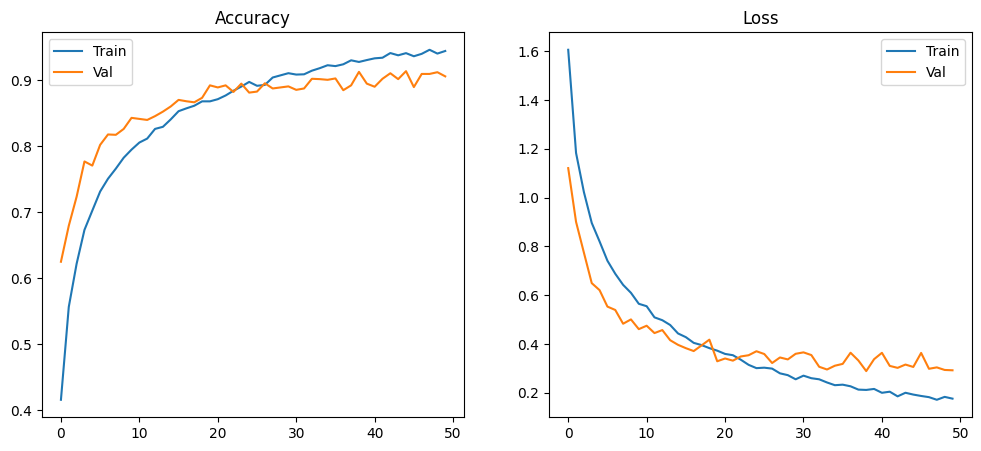

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step


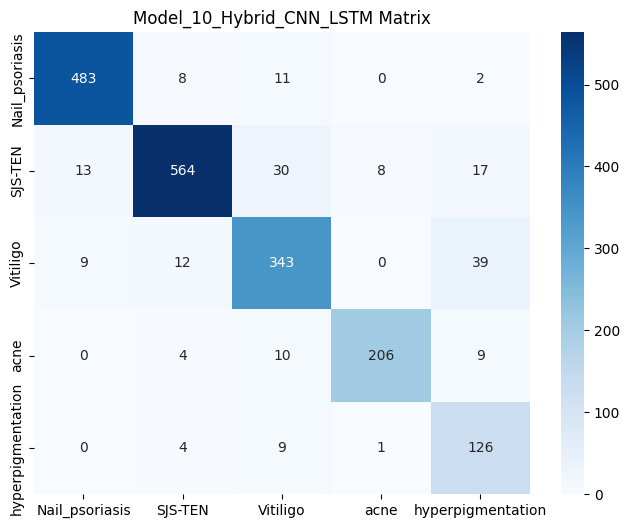

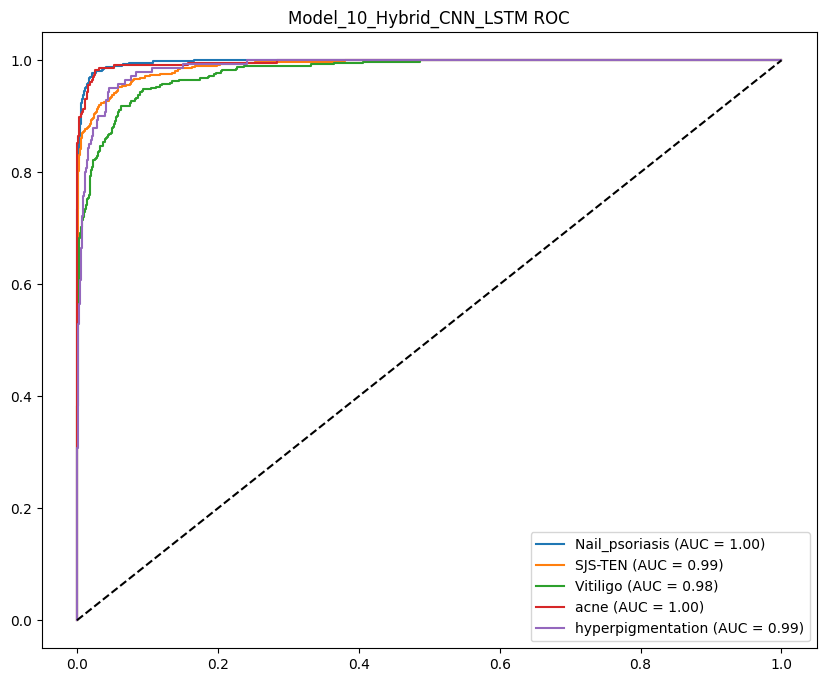

Model_10_Hybrid_CNN_LSTM ISLEMLERI TAMAMLANDI!


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2

# --- MODEL 10: HIBRIT (MobileNetV2 + LSTM)  ---
# CNN ve LSTM birlesiminde de ayni stratejiyi uyguluyorum.
# Dropout azalttim bu sayede hem gorsel hem hafıza ıyı kullanılacak.

def create_hybrid_model():
    print("Model 10 (Hibrit: MobileNetV2 + LSTM) hazirlaniyor...")

    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base.trainable = False

    model = tf.keras.models.Sequential([
        base,
        tf.keras.layers.Reshape((49, 1280)),

        # LSTM Dropout'u guncelledım(0.2)
        tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),

        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2), # Dense katmanını guncelledım

        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

if os.path.exists(f"{models_path}/Model_10_Hybrid_CNN_LSTM_best.h5"):
    try: os.remove(f"{models_path}/Model_10_Hybrid_CNN_LSTM_best.h5")
    except: pass

hybrid_model = create_hybrid_model()
train_evaluate_save(hybrid_model, "Model_10_Hybrid_CNN_LSTM", epochs=50)

/tmp/ipython-input-2709699699.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Doğruluk', data=df, palette=clrs)


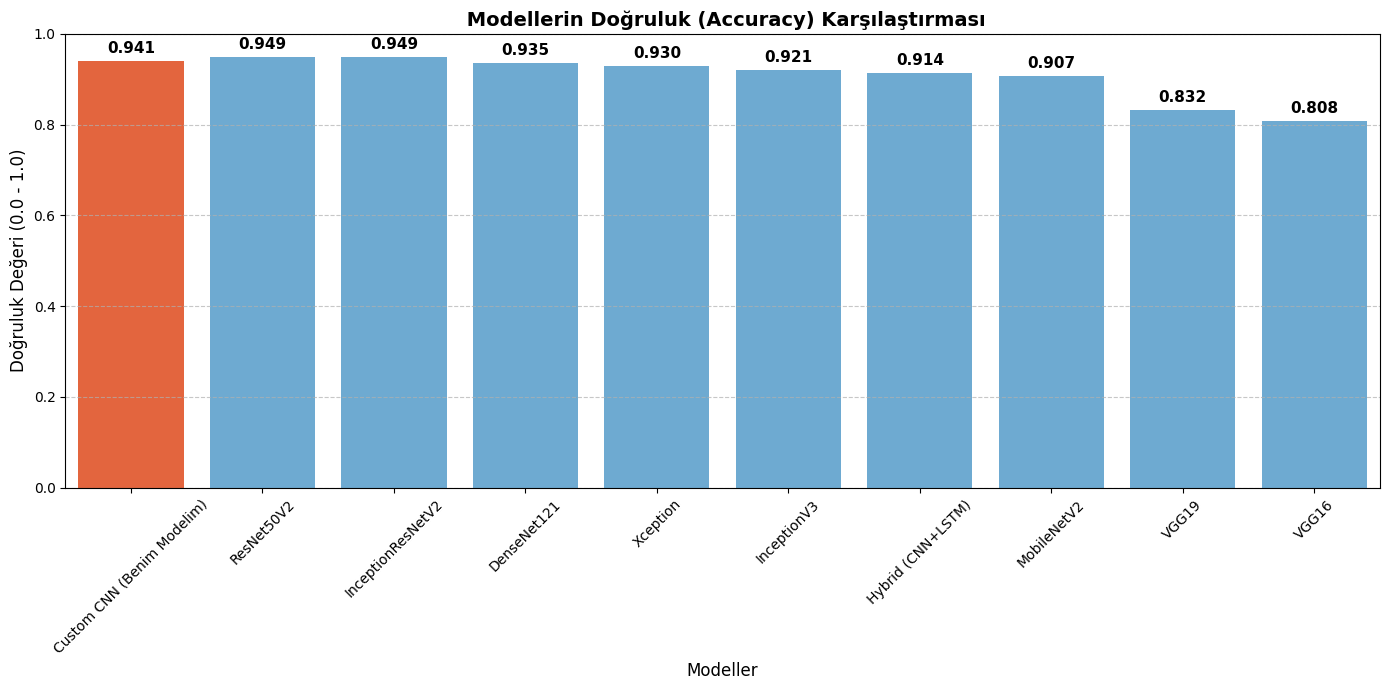

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def draw_accuracy_comparison_final_label():
    #  VERİLER (0.0 - 1.0 Aralığında)
    data = {
        'Model': [
            'Custom CNN (Benim Modelim)', 'ResNet50V2', 'InceptionResNetV2',
            'DenseNet121', 'Xception', 'InceptionV3',
            'Hybrid (CNN+LSTM)', 'MobileNetV2', 'VGG19', 'VGG16'
        ],
        'Doğruluk': [0.941, 0.949, 0.949, 0.935, 0.930, 0.921, 0.914, 0.907, 0.832, 0.808]
    }

    df = pd.DataFrame(data)

    #  GRAFİK AYARLARI
    plt.figure(figsize=(14, 7))

    # Renk Paleti: Sadece "Benim Modelim" Kırmızı, diğerleri Mavi
    clrs = ['#FF5722' if x == 'Custom CNN (Benim Modelim)' else '#5DADE2' for x in df['Model']]

    # Çizim
    ax = sns.barplot(x='Model', y='Doğruluk', data=df, palette=clrs)


    plt.ylim(0.0, 1.0) # Skala 0.0 - 1.0 arası
    plt.title(' Modellerin Doğruluk (Accuracy) Karşılaştırması', fontsize=14, fontweight='bold')
    plt.ylabel('Doğruluk Değeri (0.0 - 1.0)', fontsize=12)
    plt.xlabel('Modeller', fontsize=12)
    plt.xticks(rotation=45)

    # Sayıları Yazdırdım
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=11, fontweight='bold')

    ax.yaxis.grid(True, linestyle='--', alpha=0.7)

    # Kaydet
    plt.tight_layout()
    plt.savefig('Model_Karsilastirma_Final.png', dpi=300)
    plt.show()


draw_accuracy_comparison_final_label()